# Sequencing - Execution time + Improvement Evaluation  

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
import psycopg2
import pandas as pd
import seaborn as sns
import pandas as pd

In [94]:
# Connecting to Redshift

# Redshift Connection 
# Create a global variable for the database connection
connection = None

# Connect to Amazon Redshift
def connect_to_redshift():
    try:
        conn = psycopg2.connect(
        host='dwh-redshift.sandbox.verses.build',
            port='5439',
            database='ds_dwh',
            user='dwh_operator',
            password='G$@4333sHK^RuuYA'
        )
        print("Connected to Redshift")
        return conn
    except psycopg2.Error as e:
        print("Error connecting to Redshift:", e)
        return None

# Execute SQL query 
def execute_query(query):
    global connection
    try:
        if connection is None or connection.closed != 0:
            connection = connect_to_redshift()
        connection.autocommit = False  # Disable autocommit
        cur = connection.cursor()
        cur.execute(query)
        rows = cur.fetchall()
        column_names = [desc[0] for desc in cur.description]
        cur.close()
        connection.commit()  # Explicitly commit the transaction
        return rows, column_names
    except psycopg2.Error as e:
        connection.rollback()  # Rollback the transaction on error
        print("Error executing query:", e)
        return None, None
    finally:
        connection.autocommit = True  # Enable autocommit after query execution

# A function to create Temp Table 
def cretae_temp_table(query):
    global connection
    try:
        if connection is None or connection.closed != 0:
            connection = connect_to_redshift()
        connection.autocommit = False  # Disable autocommit
        cur = connection.cursor()
        cur.execute(query)
        cur.close()
        connection.commit()  # Explicitly commit the transaction
    except psycopg2.Error as e:
        connection.rollback()  # Rollback the transaction on error
        print("Error executing query:", e)
        return None, None
    finally:
        connection.autocommit = True  # Enable autocommit after query execution
        
# Example SQL query
query = """SELECT * FROM raw_aspire_picks 
LIMIT 100
""" 

# Create DataFrame
results, columns = execute_query(query)
df = pd.DataFrame(results, columns=columns)

Connected to Redshift


In [95]:
# RefPickData
# read from raw_aspire_picks
query = """DROP TABLE IF EXISTS RefPickData;

CREATE TEMP TABLE RefPickData AS
SELECT 
facilityname as facility_name,
employeenumber as employee_number,
assignmentnumber as assignment_number,
assignmentstarttime as assignment_start_time,
assignmentendtime as assignment_end_time,
picktypedescription as pick_type,
fastpicked as fast_picked,
taskstartdate as task_start_time,
taskenddate as task_end_time,
itemnumber as sku,
quantitypicked as quantity_picked,
taskstatusdescription as task_status,
fromlocation as location,
SPLIT_PART(fromlocation, '-', 1) AS warehouse_id,
SPLIT_PART(fromlocation, '-', 2) AS asile,
SPLIT_PART(fromlocation, '-', 3) AS section,
SPLIT_PART(fromlocation, '-', 4) AS level,
SPLIT_PART(fromlocation, '-', 5) AS column_num,
name as brand,
CASE WHEN subdocumenttype = '' THEN 'other' ELSE subdocumenttype END as order_type,
'NRI' as client
FROM raw_aspire_picks
WHERE 
DATE_TRUNC('day', taskenddate) >= '2023-01-01'
AND 
DATE_TRUNC('day', taskenddate) <= '2023-07-01'
AND 
facilityname = 'LD'
AND 
asile IN ('02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13')
AND
section IN ('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16')
AND 
"""

# read from stg_picks
query = """DROP TABLE IF EXISTS RefPickData;
CREATE TEMP TABLE RefPickData AS
SELECT 
facility_name, 
external_employee_id as employee_number, 
external_assignment_id as assignment_number, 
assignment_start_time,
assignment_end_time,
pick_type,
fast_picked,
task_start_time,
task_end_time,
sku,
quantity_picked,
task_status,
location,
SPLIT_PART(location, '-', 1) AS warehouse_id,
SPLIT_PART(location, '-', 2) AS asile,
SPLIT_PART(location, '-', 3) AS section,
SPLIT_PART(location, '-', 4) AS level,
SPLIT_PART(location, '-', 5) AS column_num,
brand,
CASE WHEN order_type = '' THEN 'other' ELSE order_type END as order_type,
client
FROM stg_picks
WHERE 
DATE_TRUNC('day', task_end_time) >= '2022-08-01'
AND 
DATE_TRUNC('day', task_end_time) <= '2023-08-01'
AND 
facility_name = 'LD'
--AND 
--asile IN ('02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13')
--AND
--section IN ('01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16')
"""

cretae_temp_table(query)

query = """SELECT * FROM RefPickData"""

# Execute the query
results, columns = execute_query(query)
df = pd.DataFrame(results, columns=columns)
total_num_records, _ = df.shape
total_num_records

1475392

In [96]:
# Find Duplicated Records 
query = """WITH duplicates AS (
    SELECT  facility_name,
            employee_number,
            assignment_number,
            assignment_start_time,
            assignment_end_time,
            pick_type,
            fast_picked,
            task_start_time,
            task_end_time,
            sku, 
            quantity_picked,
            task_status,
            location,
            asile,
            section,
            level,
            column_num,
            brand,
            order_type,
           ROW_NUMBER() OVER (PARTITION BY facility_name,
            employee_number,
            assignment_number,
            assignment_start_time,
            assignment_end_time,
            pick_type,
            fast_picked,
            task_start_time,
            task_end_time,
            sku, 
            quantity_picked,
            task_status,
            location,
            asile,
            section,
            level,
            column_num,
            brand,
            order_type) AS row_num
    FROM RefPickData)
    
    SELECT * FROM duplicates
    WHERE row_num > 1
    order by assignment_start_time
    """

results, columns = execute_query(query)
df = pd.DataFrame(results, columns=columns)
if len(df)>0:
    print("there is duplciated records")
df.head()

,facility_name,employee_number,assignment_number,assignment_start_time,assignment_end_time,pick_type,fast_picked,task_start_time,task_end_time,sku,quantity_picked,task_status,location,asile,section,level,column_num,brand,order_type,row_num


# List of all historical assignments + assignment distribution

In [97]:
# get the list of all historical assignments
query = """SELECT 
employee_number, 
assignment_start_time, 
assignment_end_time, 
assignment_number, 
pick_type,
EXTRACT(epoch FROM (assignment_end_time - assignment_start_time)) as assignment_time, 
count(*) as assignment_length,
min(task_start_time) as task_start_time, 
max(task_end_time) as task_end_time,
EXTRACT(epoch FROM (max(task_end_time) - min(task_start_time))) as total_task_time
FROM RefPickData
GROUP BY employee_number, assignment_start_time, assignment_end_time, assignment_number, pick_type
ORDER BY task_start_time DESC"""
results, columns = execute_query(query)
historical_assginment = pd.DataFrame(results, columns=columns)

historical_assginment.columns = ['hist_employee_number', 'hist_assignment_start_time', 'hist_assignment_end_time',
       'hist_assignment_number', 'pick_type', 'hist_assignment_time', 'hist_assignment_length',
       'hist_task_start_time', 'hist_task_end_time', 'total_task_time']

historical_assginment.head()

,hist_employee_number,hist_assignment_start_time,hist_assignment_end_time,hist_assignment_number,pick_type,hist_assignment_time,hist_assignment_length,hist_task_start_time,hist_task_end_time,total_task_time
0,05033,2023-08-01 23:46:21.547000+00:00,2023-08-02 00:19:41.103000+00:00,20216878,Wave Picking,1999.0,13,2023-08-01 23:48:32.183000+00:00,2023-08-01 23:59:29.277000+00:00,657.0
1,07035,2023-08-01 23:37:34.840000+00:00,2023-08-02 00:13:17.440000+00:00,20216770,Discrete Picking,2142.0,17,2023-08-01 23:39:08.003000+00:00,2023-08-01 23:59:49.417000+00:00,1241.0
2,09292,2023-08-01 23:33:33.753000+00:00,2023-08-02 00:11:16.273000+00:00,20216742,MIA Picking,2262.0,3,2023-08-01 23:33:35.827000+00:00,2023-08-01 23:45:32.370000+00:00,716.0
3,06592,2023-08-01 23:16:15.157000+00:00,2023-08-02 00:12:40.330000+00:00,20216580,Discrete Picking,3385.0,39,2023-08-01 23:19:39.407000+00:00,2023-08-01 23:59:54.340000+00:00,2414.0
4,06592,2023-08-01 23:14:20.540000+00:00,2023-08-01 23:16:01.090000+00:00,20216563,Discrete Picking,100.0,1,2023-08-01 23:15:20.143000+00:00,2023-08-01 23:15:51.037000+00:00,30.0


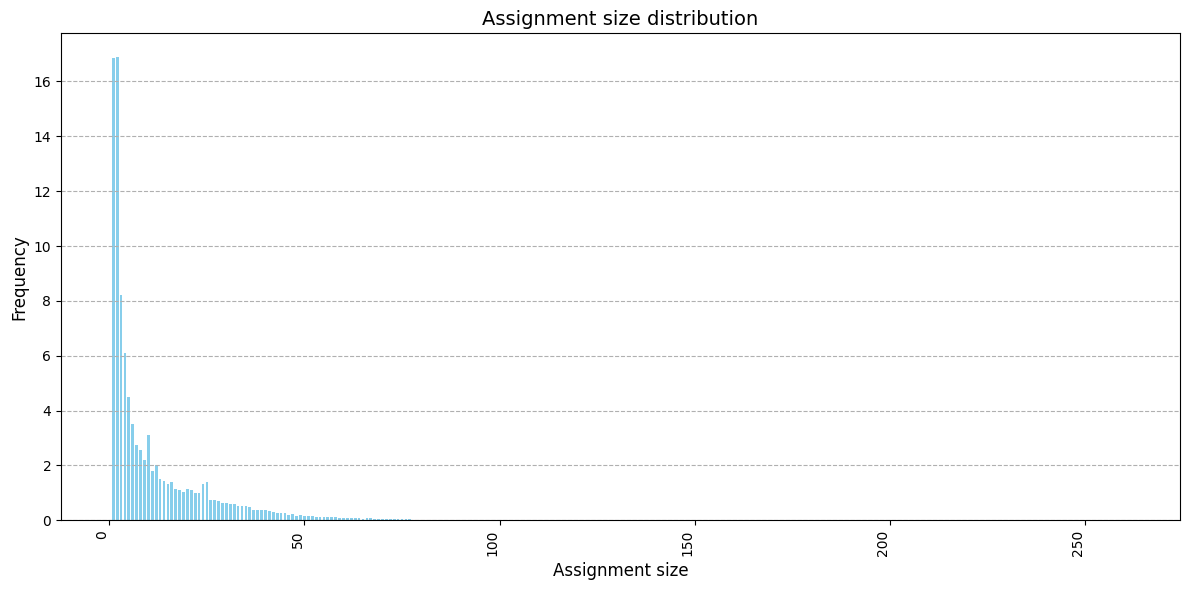

,hist_assignment_length,hist_counts,hist_freq
0,1,21572,16.84
1,2,21669,16.91
2,3,10539,8.23
3,4,7800,6.09
4,"[5,10)",19951,15.56
5,"[10,20)",20350,15.88
6,"[20, 50)",22319,17.41
7,"[50, 100)",3579,2.79
8,100+,336,0.18


In [98]:
historical_length_freq = historical_assginment[['hist_assignment_length']].value_counts().reset_index()
historical_length_freq.columns = ['hist_assignment_length', 'hist_count']
total_count = historical_length_freq['hist_count'].sum()
historical_length_freq['hist_freq'] = round((historical_length_freq['hist_count'] / total_count) * 100,2)

plt.figure(figsize=(12, 6))
plt.bar(historical_length_freq['hist_assignment_length'], historical_length_freq['hist_freq'], color='skyblue', width=0.7, align='center')
plt.xlabel('Assignment size', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Assignment size distribution', fontsize=14)
plt.xticks(rotation=90, ha='right', fontsize=10)  
plt.grid(axis='y', linestyle='--', alpha=1) 
plt.tight_layout() 
plt.savefig('plots/assignment_dist.png')
plt.show()
plt.close()

historical_length_freq.sort_values(by=['hist_assignment_length'])

bins = [1, 2, 3, 4, 5, 10, 20, 50, 100, float('inf')]  # You can adjust the bin edges as needed

labels = ['1', '2', '3', '4', '[5,10)', '[10,20)', '[20, 50)', '[50, 100)', '100+']

# Cut the 'hist_assignment_length' column into the specified bins
historical_length_freq['hist_assignment_bin'] = pd.cut(historical_length_freq['hist_assignment_length'], bins=bins, labels=labels, right=False)

result_df = historical_length_freq.groupby('hist_assignment_bin').agg({'hist_count': 'sum', 'hist_freq': 'sum'}).reset_index()
result_df.columns = ['hist_assignment_length', 'hist_counts', 'hist_freq']
result_df

# Evaluation based on exact algo

In [99]:
# Reading the results for the exact algo 
exact_analysis = pd.read_csv('analysis_data\LD_testrun_results_exact_with_DZ.csv')  # new analysis based on the data from 2022-08-01 to 2023-08-01 assuming we have the DZ
exact_analysis = exact_analysis[['AssignmentNumber', 'AssignmentLength', 'UnoptimizedDistance']]
exact_analysis.columns = ['assignment_number', 'assignment_length', 'exact_distance']
exact_analysis['assignment_number'] = exact_analysis['assignment_number'].astype('str')
exact_analysis.head()

,assignment_number,assignment_length,exact_distance
0,14734108,3,87.368785
1,14734310,6,61.978628
2,14734353,3,104.226116
3,14734540,3,131.260521
4,14735165,9,159.358508


# Evaluation based on Simulated Annealing code

In [100]:
# Load data
optimized_analysis = pd.read_csv('analysis_data\LD_testrun_results_2022-05-10.csv')  # The results based on Alex file
optimized_analysis = pd.read_csv('analysis_data\LD_testrun_results_with_DZ_v2.csv')  # The results with DZ from 2022-08-01 to 2023-08-01
#optimized_analysis = pd.read_csv('analysis_data\LD_testrun_results_without_DZ_v2.csv')  # The results without DZ from 2022-08-01 to 2023-08-01

optimized_analysis.columns = ['Unnamed: 0', 'opt_assignment_number', 'opt_assignment_length',
       'UnoptimizedSequence', 'OptimizedSequence', 'UnoptimizedDistance',
       'OptimizedDistance', 'DistanceSavings', 'SavingsPercent',
       'ExecutionTime', 'NumParallelRuns', 'Algorithm']

optimized_analysis['opt_assignment_number']=optimized_analysis['opt_assignment_number'].astype('str')
optimized_analysis=optimized_analysis.drop(columns=['Unnamed: 0'])

print(len(optimized_analysis))
print((optimized_analysis['UnoptimizedDistance'].sum() - optimized_analysis['OptimizedDistance'].sum())/optimized_analysis['UnoptimizedDistance'].sum()*100)
optimized_analysis.head()

2693
24.265947039566825


,opt_assignment_number,opt_assignment_length,UnoptimizedSequence,OptimizedSequence,UnoptimizedDistance,OptimizedDistance,DistanceSavings,SavingsPercent,ExecutionTime,NumParallelRuns,Algorithm
0,14734108,3,Delivery zone|LD-19-10-04-G|LD-19-10-04-G|LD-1...,Delivery zone|LD-19-10-04-G|LD-19-10-04-G|LD-1...,87.368785,87.368785,0.000000e+00,0.000000e+00,9.787476,4,annealing
1,14734310,6,Delivery zone|LD-14-06-03-F|LD-14-02-03-G|LD-1...,Delivery zone|LD-14-06-03-F|LD-14-02-03-G|LD-1...,61.978628,64.628845,-2.650216e+00,-4.276017e-02,10.919090,4,annealing
2,14734353,3,Delivery zone|LD-79-03-03-F|LD-79-07-03-H|LD-D...,Delivery zone|LD-79-07-03-H|LD-79-03-03-F|LD-D...,104.226116,104.226116,-2.842171e-14,-2.726928e-16,11.449789,4,annealing
3,14734540,3,Delivery zone|LD-75-15-03-A|LD-80-10-03-I|LD-8...,Delivery zone|LD-80-10-03-I|LD-80-01-03-B|LD-7...,131.260521,131.260521,0.000000e+00,0.000000e+00,10.599159,4,annealing
4,14735165,9,Delivery zone|LD-14-14-02-G|LD-14-14-03-B|LD-7...,Delivery zone|LD-14-14-03-B|LD-14-14-02-G|LD-7...,238.485256,159.358508,7.912675e+01,3.317888e-01,14.062672,4,annealing


# Evaluation based on routing version 2

In [101]:
# Reading the results for the new graph 
new_graph_df = pd.read_csv('analysis_data\LD_results_2022-05-10_new_graph.csv')  # results on routing v2 using Alex file 
new_graph_df = pd.read_csv('analysis_data\path_finding_with_DZ_new_graph_v2.csv')  # results on routing v2 with DZ 
#new_graph_df = pd.read_csv('analysis_data\path_finding_without_DZ_new_graph_v2.csv')  # results on routing v2 without DZ 
new_graph_df=new_graph_df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
new_graph_df['AssignmentNumber'] = new_graph_df['AssignmentNumber'].astype('str')
new_graph_df.head()

,opt,unopt,AssignmentNumber,AssignmentLength,UnoptimizedSequence,OptimizedSequence,UnoptimizedDistance,OptimizedDistance,DistanceSavings,SavingsPercent,ExecutionTime,NumParallelRuns,Algorithm,unopt_seq,opt_seq
0,10.90,10.90,14734108,3,Delivery zone|LD-19-10-04-G|LD-19-10-04-G|LD-1...,Delivery zone|LD-19-10-04-G|LD-19-10-04-G|LD-1...,87.368785,87.368785,0.000000e+00,0.000000e+00,9.787476,4,annealing,"['Delivery zone', 'LD-19-10-04-G', 'LD-19-14-0...","['Delivery zone', 'LD-19-10-04-G', 'LD-19-14-0..."
1,11.19,11.65,14734310,6,Delivery zone|LD-14-06-03-F|LD-14-02-03-G|LD-1...,Delivery zone|LD-14-06-03-F|LD-14-02-03-G|LD-1...,61.978628,64.628845,-2.650216e+00,-4.276017e-02,10.919090,4,annealing,"['Delivery zone', 'LD-14-06-03-F', 'LD-14-02-0...","['Delivery zone', 'LD-14-06-03-F', 'LD-14-02-0..."
2,57.23,48.95,14734353,3,Delivery zone|LD-79-03-03-F|LD-79-07-03-H|LD-D...,Delivery zone|LD-79-07-03-H|LD-79-03-03-F|LD-D...,104.226116,104.226116,-2.842171e-14,-2.726928e-16,11.449789,4,annealing,"['Delivery zone', 'LD-79-03-03-F', 'LD-79-07-0...","['Delivery zone', 'LD-79-07-03-H', 'LD-79-03-0..."
3,54.55,41.33,14734540,3,Delivery zone|LD-75-15-03-A|LD-80-10-03-I|LD-8...,Delivery zone|LD-80-10-03-I|LD-80-01-03-B|LD-7...,131.260521,131.260521,0.000000e+00,0.000000e+00,10.599159,4,annealing,"['Delivery zone', 'LD-75-15-03-A', 'LD-80-10-0...","['Delivery zone', 'LD-80-10-03-I', 'LD-80-01-0..."
4,109.02,170.73,14735165,9,Delivery zone|LD-14-14-02-G|LD-14-14-03-B|LD-7...,Delivery zone|LD-14-14-03-B|LD-14-14-02-G|LD-7...,238.485256,159.358508,7.912675e+01,3.317888e-01,14.062672,4,annealing,"['Delivery zone', 'LD-14-14-02-G', 'LD-14-14-0...","['Delivery zone', 'LD-14-14-03-B', 'LD-14-14-0..."


# Exact analysis 

C:\Users\Hasan\AppData\Local\Temp\ipykernel_22536\2311371870.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  exact_optimized_groupby_df= exact_optimized_df.groupby('opt_assignment_length').sum().reset_index()


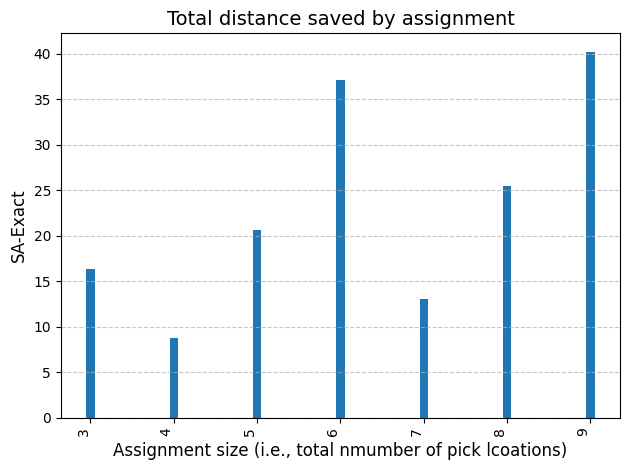

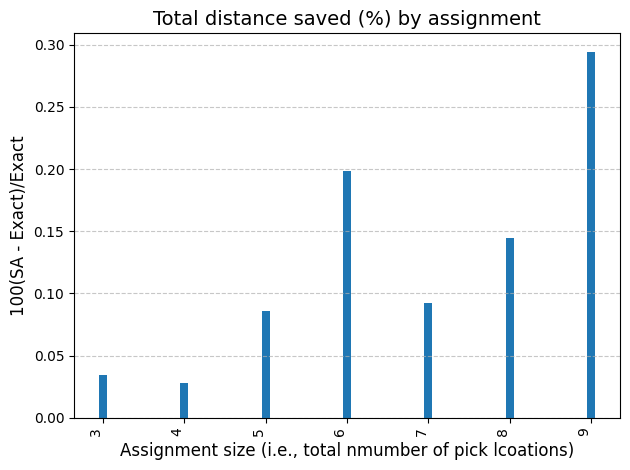

,opt_assignment_length,UnoptimizedDistance,OptimizedDistance,DistanceSavings,SavingsPercent,ExecutionTime,NumParallelRuns,assignment_length,exact_distance,Unoptimized - exact,worst,equal,Optimized - exact
0,3.0,48943.648620,47858.409766,1085.238854,6.708778,4987.997231,1856.0,1392,47842.094025,1101.554594,214,250,16.315740
1,4.0,32400.684550,31076.823452,1323.861098,8.825184,2965.840580,1092.0,1092,31068.004420,1332.680129,166,107,8.819031
2,5.0,26037.552213,24146.865687,1890.686526,11.534513,4239.317149,808.0,1010,24126.167238,1911.384975,152,50,20.698449
3,6.0,20515.308651,18762.211046,1753.097605,9.931438,1541.790899,564.0,846,18725.047656,1790.260994,122,19,37.163389
4,7.0,15787.585604,14157.130323,1630.455281,9.381554,1142.136261,416.0,728,14144.018357,1643.567247,91,13,13.111966


<Figure size 1200x600 with 0 Axes>

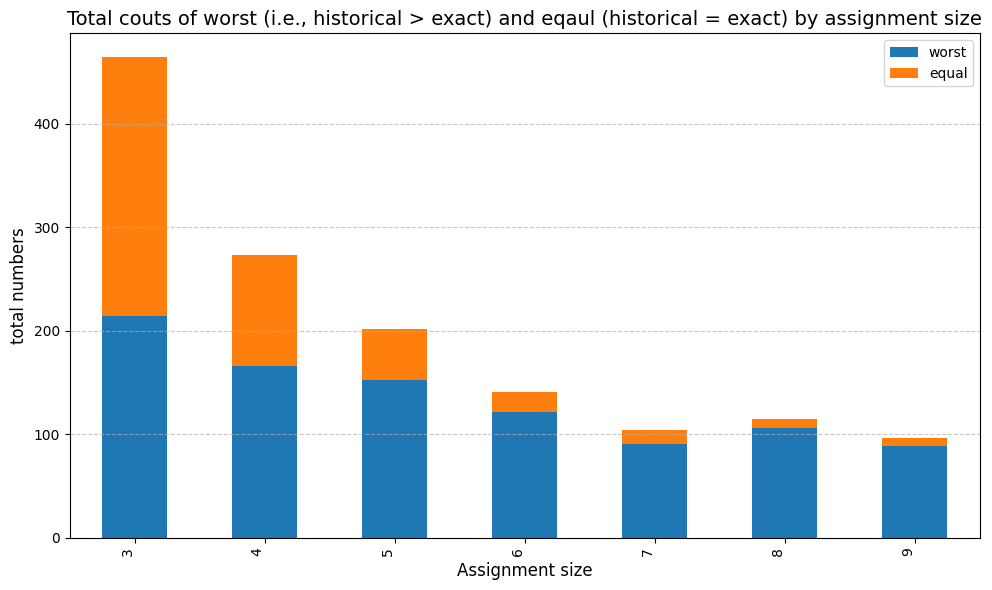

In [102]:
# Analysis of the results based on exact solution
exact_optimized_df = pd.merge(optimized_analysis, 
                              exact_analysis, 
                              left_on = 'opt_assignment_number', 
                              right_on = 'assignment_number', 
                              how= 'right')

exact_optimized_df['Unoptimized - exact'] = exact_optimized_df['UnoptimizedDistance'] - exact_optimized_df['exact_distance']
exact_optimized_df['worst'] = (exact_optimized_df['Unoptimized - exact']> 0).astype(int)
exact_optimized_df['equal'] = (exact_optimized_df['Unoptimized - exact'] == 0).astype(int)

exact_optimized_df['Optimized - exact'] = exact_optimized_df['OptimizedDistance'] - exact_optimized_df['exact_distance']

exact_optimized_groupby_df= exact_optimized_df.groupby('opt_assignment_length').sum().reset_index()

plt.bar(exact_optimized_groupby_df['opt_assignment_length'], exact_optimized_groupby_df['Optimized - exact'], width=0.1)
plt.xlabel('Assignment size (i.e., total nmumber of pick lcoations)', fontsize=12)
plt.ylabel('SA-Exact', fontsize=12)
plt.title('Total distance saved by assignment', fontsize=14)
plt.xticks(rotation=90, ha='right', fontsize=10)  
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout() 
plt.savefig('plots/exact_optimized_distance.png')
plt.show()

plt.bar(exact_optimized_groupby_df['opt_assignment_length'], 
        exact_optimized_groupby_df['Optimized - exact']/exact_optimized_groupby_df['exact_distance']*100, width=0.1)
plt.xlabel('Assignment size (i.e., total nmumber of pick lcoations)', fontsize=12)
plt.ylabel('100(SA - Exact)/Exact', fontsize=12)
plt.title('Total distance saved (%) by assignment', fontsize=14)
plt.xticks(rotation=90, ha='right', fontsize=10)  
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout() 
plt.savefig('plots/exact_optimized_distance (%).png')
plt.show()

# Plot the bar chart
plt.figure(figsize=(12, 6))
df = exact_optimized_groupby_df[['opt_assignment_length', 'worst', 'equal']].set_index('opt_assignment_length')
df.index = df.index.astype(int)
ax = df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Assignment size', fontsize=12)
plt.ylabel('total numbers', fontsize=12)
plt.title('Total couts of worst (i.e., historical > exact) and eqaul (historical = exact) by assignment size', fontsize=14)
plt.xticks(rotation=90, ha='right', fontsize=10)  
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout() 
plt.savefig('plots/exact_worst_better.png')

exact_optimized_groupby_df.head()

# SA results on original graph + assignment data

In [103]:
# join optimized_analysis with assignment data 
optimized_analysis['opt_assignment_number'] = optimized_analysis['opt_assignment_number'].astype(str)
historical_assginment['hist_assignment_number'] = historical_assginment['hist_assignment_number'].astype(str)

historical_assginment = historical_assginment.drop_duplicates(subset='hist_assignment_number', keep='first')

historical_versus_optimzied_df = pd.merge(optimized_analysis, 
                                          historical_assginment, 
                                          left_on='opt_assignment_number', 
                                          right_on='hist_assignment_number', 
                                          how = 'left')

historical_versus_optimzied_df = historical_versus_optimzied_df[['opt_assignment_number', 
                                                                 'opt_assignment_length', 
                                                                 'hist_assignment_number', 
                                                                 'hist_assignment_length',
                                                                 'pick_type',
                                                                 'UnoptimizedSequence', 'OptimizedSequence', 'UnoptimizedDistance', 'OptimizedDistance', 
                                                                 'DistanceSavings', 'SavingsPercent',
                                                                 'ExecutionTime', 'NumParallelRuns', 'Algorithm', 
                                                                 'hist_employee_number', 
                                                                 'hist_assignment_start_time', 'hist_assignment_end_time', 'hist_assignment_time', 
                                                                 'hist_task_start_time', 'hist_task_end_time', 'total_task_time']]

# add columns 
historical_versus_optimzied_df['better'] = (historical_versus_optimzied_df['DistanceSavings'] > 0).astype(int)
historical_versus_optimzied_df['equal'] = (historical_versus_optimzied_df['DistanceSavings'] == 0).astype(int)
historical_versus_optimzied_df['worst'] = (historical_versus_optimzied_df['DistanceSavings'] < 0).astype(int)

historical_versus_optimzied_df['opt_assignment_number'] = historical_versus_optimzied_df['opt_assignment_number'].astype(str)
historical_versus_optimzied_df['opt_assignment_length'] = historical_versus_optimzied_df['opt_assignment_length'].astype(int)
historical_versus_optimzied_df['hist_assignment_number'] = historical_versus_optimzied_df['hist_assignment_number'].astype(str)
historical_versus_optimzied_df['UnoptimizedDistance'] = historical_versus_optimzied_df['UnoptimizedDistance'].astype(float)
historical_versus_optimzied_df['OptimizedDistance'] = historical_versus_optimzied_df['OptimizedDistance'].astype(float)
historical_versus_optimzied_df['DistanceSavings'] = historical_versus_optimzied_df['DistanceSavings'].astype(float)
historical_versus_optimzied_df['SavingsPercent'] = historical_versus_optimzied_df['SavingsPercent'].astype(float)
historical_versus_optimzied_df['ExecutionTime'] = historical_versus_optimzied_df['ExecutionTime'].astype(float)
historical_versus_optimzied_df['NumParallelRuns'] = historical_versus_optimzied_df['NumParallelRuns'].astype(str)
historical_versus_optimzied_df['hist_employee_number'] = historical_versus_optimzied_df['hist_employee_number'].astype(str)
historical_versus_optimzied_df['hist_assignment_start_time'] = pd.to_datetime(historical_versus_optimzied_df['hist_assignment_start_time'])
historical_versus_optimzied_df['hist_assignment_end_time'] = pd.to_datetime(historical_versus_optimzied_df['hist_assignment_end_time'])
historical_versus_optimzied_df['hist_assignment_time'] = historical_versus_optimzied_df['hist_assignment_time'].astype('float')
historical_versus_optimzied_df['hist_task_start_time'] = pd.to_datetime(historical_versus_optimzied_df['hist_task_start_time'])
historical_versus_optimzied_df['hist_task_end_time'] = pd.to_datetime(historical_versus_optimzied_df['hist_task_end_time'])

if len(historical_versus_optimzied_df[historical_versus_optimzied_df.isna().any(axis=1)])>0:
    print('Warning: We have NA data')
else: 
    print('Data is looking good')

historical_versus_optimzied_df[['opt_assignment_number', 
                                'hist_assignment_length', 
                                'UnoptimizedSequence', 
                                'OptimizedSequence', 
                                'UnoptimizedDistance', 
                                'OptimizedDistance', 
                                'DistanceSavings', 
                                'SavingsPercent']].sort_values(by='SavingsPercent', ascending=False).head()

historical_versus_optimzied_df.head()

Data is looking good


,opt_assignment_number,opt_assignment_length,hist_assignment_number,hist_assignment_length,pick_type,UnoptimizedSequence,OptimizedSequence,UnoptimizedDistance,OptimizedDistance,DistanceSavings,...,hist_employee_number,hist_assignment_start_time,hist_assignment_end_time,hist_assignment_time,hist_task_start_time,hist_task_end_time,total_task_time,better,equal,worst
0,14734108,3,14734108,3,Discrete Picking,Delivery zone|LD-19-10-04-G|LD-19-10-04-G|LD-1...,Delivery zone|LD-19-10-04-G|LD-19-10-04-G|LD-1...,87.368785,87.368785,0.000000e+00,...,02044,2022-08-01 12:48:15.587000+00:00,2022-08-01 12:51:03.503000+00:00,167.0,2022-08-01 12:48:37.990000+00:00,2022-08-01 12:50:53.780000+00:00,135.0,0,1,0
1,14734310,6,14734310,6,Discrete Picking,Delivery zone|LD-14-06-03-F|LD-14-02-03-G|LD-1...,Delivery zone|LD-14-06-03-F|LD-14-02-03-G|LD-1...,61.978628,64.628845,-2.650216e+00,...,06038,2022-08-01 13:01:15.253000+00:00,2022-08-01 13:12:02.783000+00:00,647.0,2022-08-01 13:05:26.983000+00:00,2022-08-01 13:10:32+00:00,305.0,0,0,1
2,14734353,3,14734353,3,Discrete Picking,Delivery zone|LD-79-03-03-F|LD-79-07-03-H|LD-D...,Delivery zone|LD-79-07-03-H|LD-79-03-03-F|LD-D...,104.226116,104.226116,-2.842171e-14,...,05064,2022-08-01 13:04:37.053000+00:00,2022-08-01 13:08:48.760000+00:00,251.0,2022-08-01 13:05:45.130000+00:00,2022-08-01 13:08:38.817000+00:00,173.0,0,0,1
3,14734540,3,14734540,3,Discrete Picking,Delivery zone|LD-75-15-03-A|LD-80-10-03-I|LD-8...,Delivery zone|LD-80-10-03-I|LD-80-01-03-B|LD-7...,131.260521,131.260521,0.000000e+00,...,05064,2022-08-01 13:16:53.363000+00:00,2022-08-01 13:20:15.683000+00:00,202.0,2022-08-01 13:17:45.077000+00:00,2022-08-01 13:19:56.163000+00:00,131.0,0,1,0
4,14735165,9,14735165,9,Discrete Picking,Delivery zone|LD-14-14-02-G|LD-14-14-03-B|LD-7...,Delivery zone|LD-14-14-03-B|LD-14-14-02-G|LD-7...,238.485256,159.358508,7.912675e+01,...,06038,2022-08-01 13:48:40.697000+00:00,2022-08-01 13:59:18.863000+00:00,638.0,2022-08-01 13:50:06.257000+00:00,2022-08-01 13:59:18.823000+00:00,552.0,1,0,0


# SA results o new graph evaluated on routing V2 + SA + historical assignment

In [111]:
# join historical_versus_optimzied_df with new_graph_df
new_graph_df['AssignmentNumber'] = new_graph_df['AssignmentNumber'].astype('str')

new_graph = new_graph_df[['opt', 
                          'unopt', 
                          'AssignmentNumber',
                          'AssignmentLength',  
                          'unopt_seq', 
                          'opt_seq']]

# we are joining on the right due to the fact that we may not have all data in new_graph
historical_versus_optimzied_new_graph_df = pd.merge(historical_versus_optimzied_df, 
                                          new_graph, 
                                          left_on='opt_assignment_number', 
                                          right_on='AssignmentNumber', 
                                          how = 'right')
# what percentage of the data is missed
print((len(historical_versus_optimzied_df)-len(historical_versus_optimzied_new_graph_df))/len(historical_versus_optimzied_df)*100)

historical_versus_optimzied_new_graph = historical_versus_optimzied_new_graph_df[['opt_assignment_number', 
                                                                                  'hist_employee_number',
                                                                                  'opt_assignment_length',
                                                                                  'pick_type',
                                                                                  'UnoptimizedDistance',
                                                                                  'OptimizedDistance',
                                                                                  'unopt',	
                                                                                  'opt',	
                                                                                  'UnoptimizedSequence', 
                                                                                  'OptimizedSequence', 
                                                                                  'unopt_seq', 
                                                                                  'opt_seq', 
                                                                                  'DistanceSavings',
                                                                                  'SavingsPercent',
                                                                                  'ExecutionTime', 
                                                                                  'NumParallelRuns', 
                                                                                  'Algorithm',
                                                                                  'better', 
                                                                                  'equal', 
                                                                                  'worst', 
                                                                                  'hist_assignment_start_time',	
                                                                                  'hist_assignment_end_time',
                                                                                  'hist_assignment_time',
                                                                                  'hist_task_start_time',	
                                                                                  'hist_task_end_time',
                                                                                  'total_task_time'
                                                                                 ]]

historical_versus_optimzied_new_graph.head() # This includes SA solution on original graph, on new graph, and assignment information

0.0


,opt_assignment_number,hist_employee_number,opt_assignment_length,pick_type,UnoptimizedDistance,OptimizedDistance,unopt,opt,UnoptimizedSequence,OptimizedSequence,...,Algorithm,better,equal,worst,hist_assignment_start_time,hist_assignment_end_time,hist_assignment_time,hist_task_start_time,hist_task_end_time,total_task_time
0,14734108,02044,3,Discrete Picking,87.368785,87.368785,10.90,10.90,Delivery zone|LD-19-10-04-G|LD-19-10-04-G|LD-1...,Delivery zone|LD-19-10-04-G|LD-19-10-04-G|LD-1...,...,annealing,0,1,0,2022-08-01 12:48:15.587000+00:00,2022-08-01 12:51:03.503000+00:00,167.0,2022-08-01 12:48:37.990000+00:00,2022-08-01 12:50:53.780000+00:00,135.0
1,14734310,06038,6,Discrete Picking,61.978628,64.628845,11.65,11.19,Delivery zone|LD-14-06-03-F|LD-14-02-03-G|LD-1...,Delivery zone|LD-14-06-03-F|LD-14-02-03-G|LD-1...,...,annealing,0,0,1,2022-08-01 13:01:15.253000+00:00,2022-08-01 13:12:02.783000+00:00,647.0,2022-08-01 13:05:26.983000+00:00,2022-08-01 13:10:32+00:00,305.0
2,14734353,05064,3,Discrete Picking,104.226116,104.226116,48.95,57.23,Delivery zone|LD-79-03-03-F|LD-79-07-03-H|LD-D...,Delivery zone|LD-79-07-03-H|LD-79-03-03-F|LD-D...,...,annealing,0,0,1,2022-08-01 13:04:37.053000+00:00,2022-08-01 13:08:48.760000+00:00,251.0,2022-08-01 13:05:45.130000+00:00,2022-08-01 13:08:38.817000+00:00,173.0
3,14734540,05064,3,Discrete Picking,131.260521,131.260521,41.33,54.55,Delivery zone|LD-75-15-03-A|LD-80-10-03-I|LD-8...,Delivery zone|LD-80-10-03-I|LD-80-01-03-B|LD-7...,...,annealing,0,1,0,2022-08-01 13:16:53.363000+00:00,2022-08-01 13:20:15.683000+00:00,202.0,2022-08-01 13:17:45.077000+00:00,2022-08-01 13:19:56.163000+00:00,131.0
4,14735165,06038,9,Discrete Picking,238.485256,159.358508,170.73,109.02,Delivery zone|LD-14-14-02-G|LD-14-14-03-B|LD-7...,Delivery zone|LD-14-14-03-B|LD-14-14-02-G|LD-7...,...,annealing,1,0,0,2022-08-01 13:48:40.697000+00:00,2022-08-01 13:59:18.863000+00:00,638.0,2022-08-01 13:50:06.257000+00:00,2022-08-01 13:59:18.823000+00:00,552.0


In [112]:
# filter the data you need 
# filter_historical_versus_optimzied_df = historical_versus_optimzied_df[(historical_versus_optimzied_df['opt_assignment_length']<=10)]
filter_historical_versus_optimzied_df = historical_versus_optimzied_new_graph

filter_historical_versus_optimzied_df['num_tasks'] = filter_historical_versus_optimzied_df['opt_assignment_length']
filter_historical_versus_optimzied_df.to_csv('Analysis_without_DZ_LD.csv')

C:\Users\Hasan\AppData\Local\Temp\ipykernel_22536\2995754159.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_historical_versus_optimzied_df['num_tasks'] = filter_historical_versus_optimzied_df['opt_assignment_length']


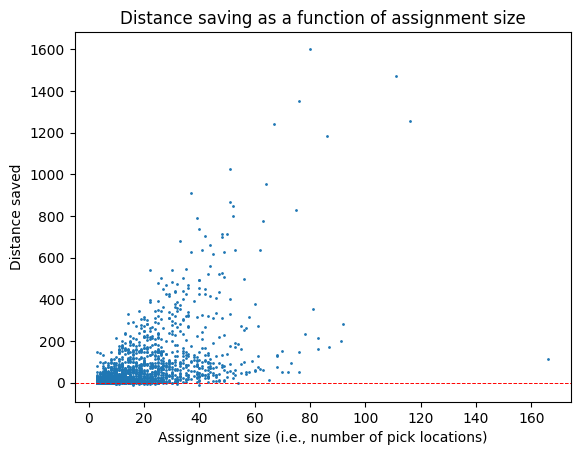

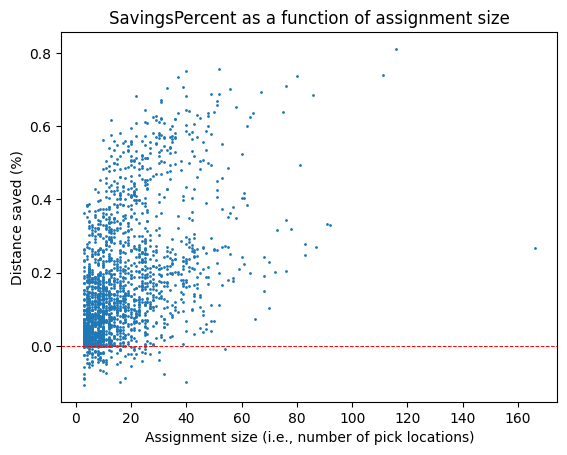

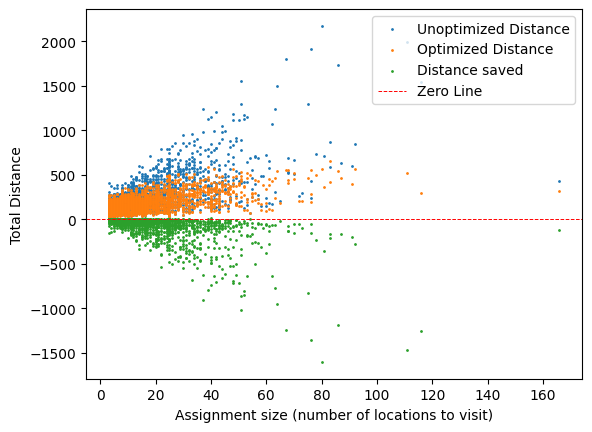

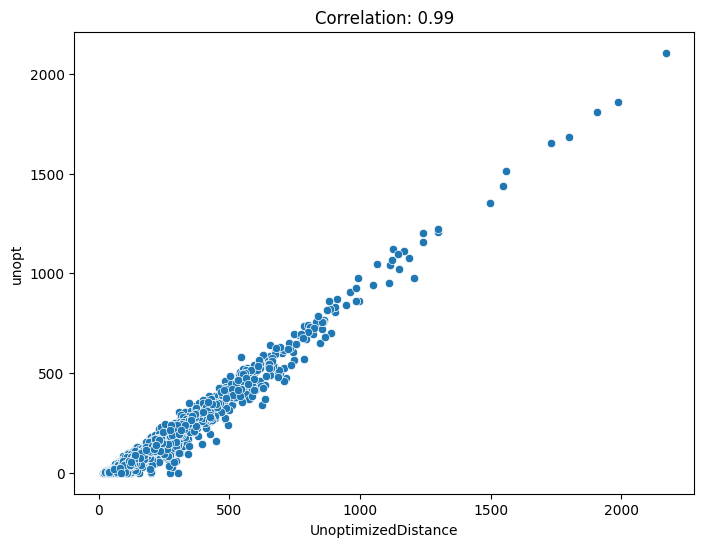

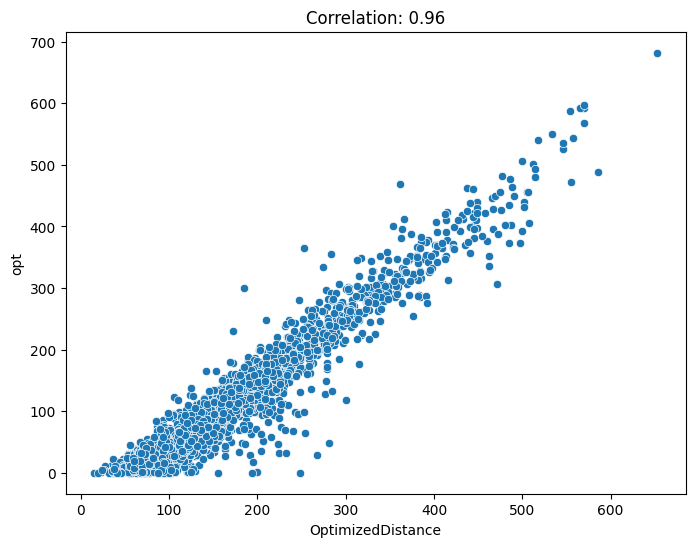

,opt_assignment_number,hist_employee_number,opt_assignment_length,pick_type,UnoptimizedDistance,OptimizedDistance,unopt,opt,UnoptimizedSequence,OptimizedSequence,...,better,equal,worst,hist_assignment_start_time,hist_assignment_end_time,hist_assignment_time,hist_task_start_time,hist_task_end_time,total_task_time,num_tasks
0,14734108,02044,3,Discrete Picking,87.368785,87.368785,10.90,10.90,Delivery zone|LD-19-10-04-G|LD-19-10-04-G|LD-1...,Delivery zone|LD-19-10-04-G|LD-19-10-04-G|LD-1...,...,0,1,0,2022-08-01 12:48:15.587000+00:00,2022-08-01 12:51:03.503000+00:00,167.0,2022-08-01 12:48:37.990000+00:00,2022-08-01 12:50:53.780000+00:00,135.0,3
1,14734310,06038,6,Discrete Picking,61.978628,64.628845,11.65,11.19,Delivery zone|LD-14-06-03-F|LD-14-02-03-G|LD-1...,Delivery zone|LD-14-06-03-F|LD-14-02-03-G|LD-1...,...,0,0,1,2022-08-01 13:01:15.253000+00:00,2022-08-01 13:12:02.783000+00:00,647.0,2022-08-01 13:05:26.983000+00:00,2022-08-01 13:10:32+00:00,305.0,6
2,14734353,05064,3,Discrete Picking,104.226116,104.226116,48.95,57.23,Delivery zone|LD-79-03-03-F|LD-79-07-03-H|LD-D...,Delivery zone|LD-79-07-03-H|LD-79-03-03-F|LD-D...,...,0,0,1,2022-08-01 13:04:37.053000+00:00,2022-08-01 13:08:48.760000+00:00,251.0,2022-08-01 13:05:45.130000+00:00,2022-08-01 13:08:38.817000+00:00,173.0,3
3,14734540,05064,3,Discrete Picking,131.260521,131.260521,41.33,54.55,Delivery zone|LD-75-15-03-A|LD-80-10-03-I|LD-8...,Delivery zone|LD-80-10-03-I|LD-80-01-03-B|LD-7...,...,0,1,0,2022-08-01 13:16:53.363000+00:00,2022-08-01 13:20:15.683000+00:00,202.0,2022-08-01 13:17:45.077000+00:00,2022-08-01 13:19:56.163000+00:00,131.0,3
4,14735165,06038,9,Discrete Picking,238.485256,159.358508,170.73,109.02,Delivery zone|LD-14-14-02-G|LD-14-14-03-B|LD-7...,Delivery zone|LD-14-14-03-B|LD-14-14-02-G|LD-7...,...,1,0,0,2022-08-01 13:48:40.697000+00:00,2022-08-01 13:59:18.863000+00:00,638.0,2022-08-01 13:50:06.257000+00:00,2022-08-01 13:59:18.823000+00:00,552.0,9


In [113]:
import seaborn as sns
# plot distance saved as a function of assignment size *individual assignments*

data = filter_historical_versus_optimzied_df

plt.scatter(data['opt_assignment_length'], data['DistanceSavings'], s=1)
plt.ylabel('Distance saved')
plt.xlabel('Assignment size (i.e., number of pick locations)')
plt.title('Distance saving as a function of assignment size')
plt.axhline(0, color='red', linestyle='--', linewidth=0.7, label="Zero Line")
plt.savefig('plots/distancesaving.png')
plt.show()

plt.scatter(data['opt_assignment_length'], data['SavingsPercent'], s=1)
plt.ylabel('Distance saved (%)')
plt.xlabel('Assignment size (i.e., number of pick locations)')
plt.title('SavingsPercent as a function of assignment size')
plt.axhline(0, color='red', linestyle='--', linewidth=0.7, label="Zero Line")
plt.savefig('plots/distance_saved_percentage.png')
plt.show()

x = data["opt_assignment_length"]
y1 = data["UnoptimizedDistance"]
y2 = data["OptimizedDistance"]
y3 = data["OptimizedDistance"] - data["UnoptimizedDistance"]
y4 = data["unopt"]
y5 = data["opt"]
y6 = data["opt"] - data["unopt"]

plt.scatter(x, y1, label="Unoptimized Distance", s=1)
plt.scatter(x, y2, label="Optimized Distance", s=1)
plt.scatter(x, y3, label="Distance saved", s=1)
# plt.scatter(x, y4, label="Unoptimized Distance (new graph)", s=1)
# plt.scatter(x, y5, label="Optimized Distance (new graph)", s=1)
# plt.scatter(x, y6, label="Distance saved (new graph)", s=1)
plt.axhline(0, color='red', linestyle='--', linewidth=0.7, label="Zero Line")
plt.xlabel("Assignment size (number of locations to visit)")
plt.ylabel("Total Distance")
plt.legend()
plt.savefig('plots/unoptimized_optimized.png')
plt.show()

correlation = data['UnoptimizedDistance'].corr(data['unopt'])
plt.figure(figsize=(8, 6))
sns.scatterplot(x='UnoptimizedDistance', y='unopt', data=data)
plt.title(f'Correlation: {correlation:.2f}')
plt.xlabel('UnoptimizedDistance')
plt.ylabel('unopt')
plt.show()

correlation = data['OptimizedDistance'].corr(data['opt'])
plt.figure(figsize=(8, 6))
sns.scatterplot(x='OptimizedDistance', y='opt', data=data)
plt.title(f'Correlation: {correlation:.2f}')
plt.xlabel('OptimizedDistance')
plt.ylabel('opt')
plt.show()

data.head()

range(4, 120, 5)


C:\Users\Hasan\AppData\Local\Temp\ipykernel_22536\2762190502.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_historical_versus_optimzied_df['DistanceSavings (new graph)'] = filter_historical_versus_optimzied_df['unopt'] - filter_historical_versus_optimzied_df['opt']


<Figure size 1200x600 with 0 Axes>

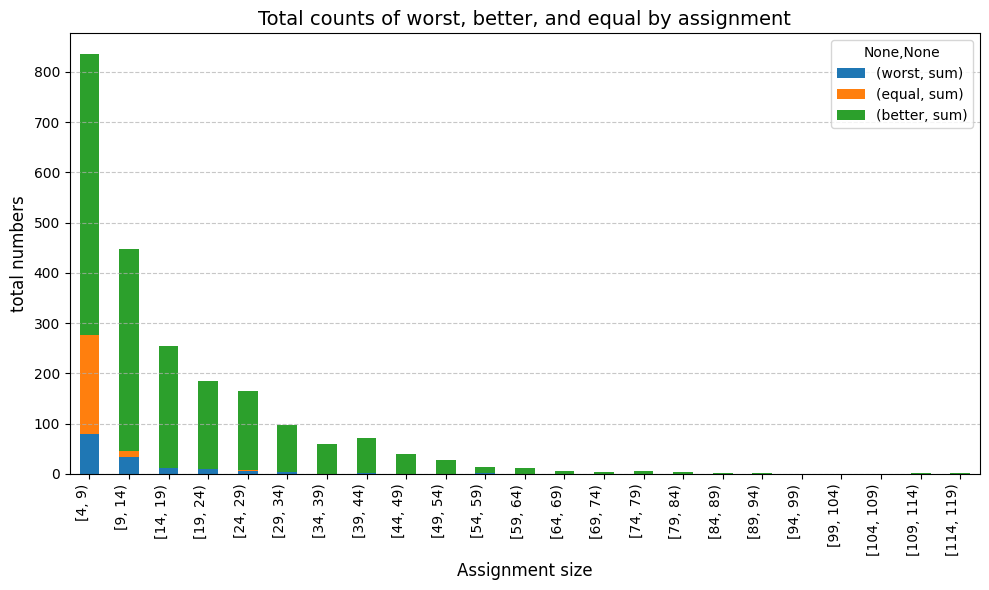

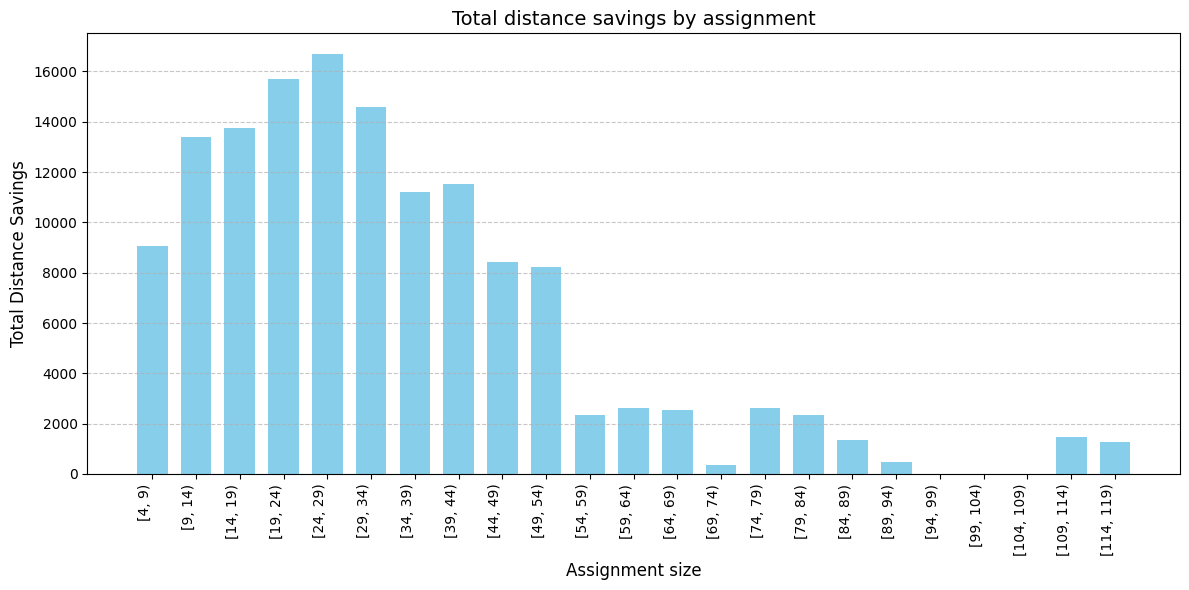

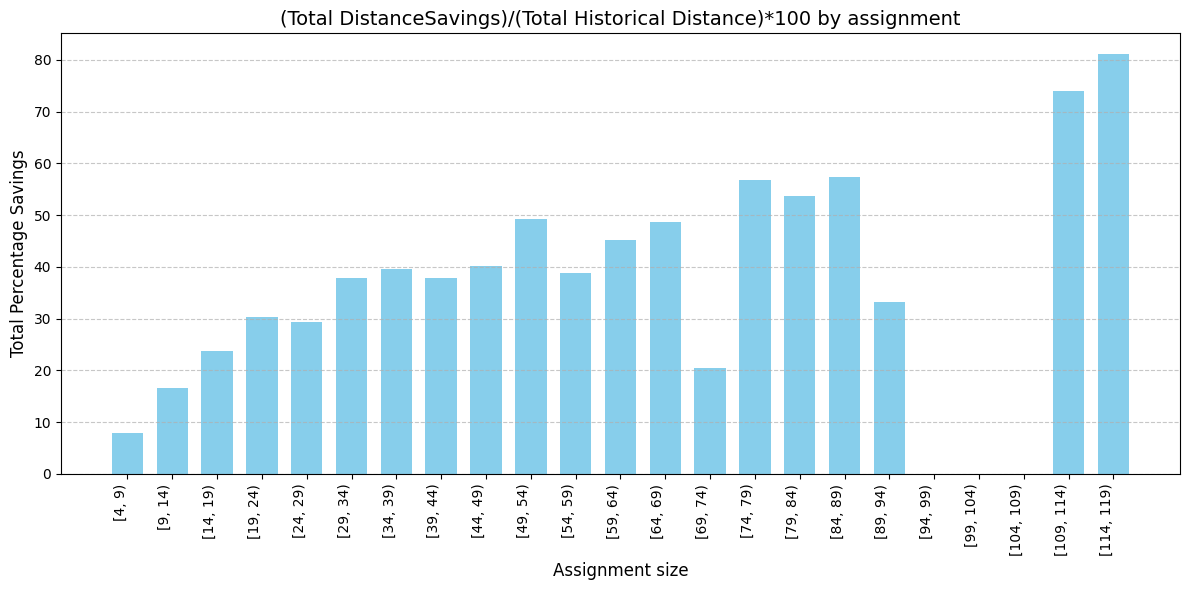

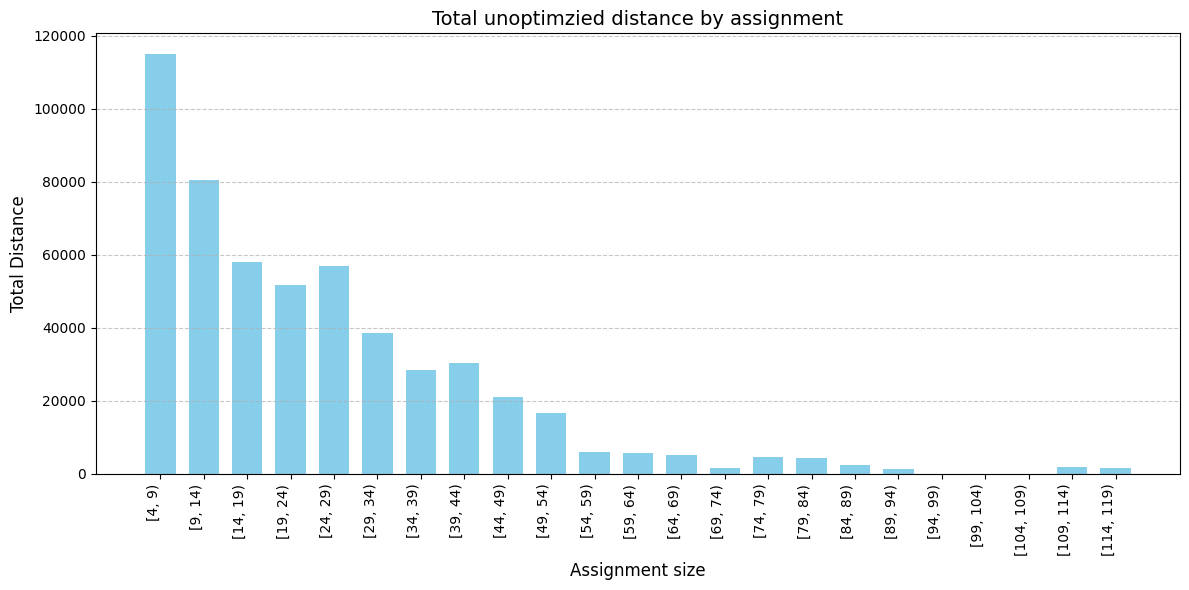

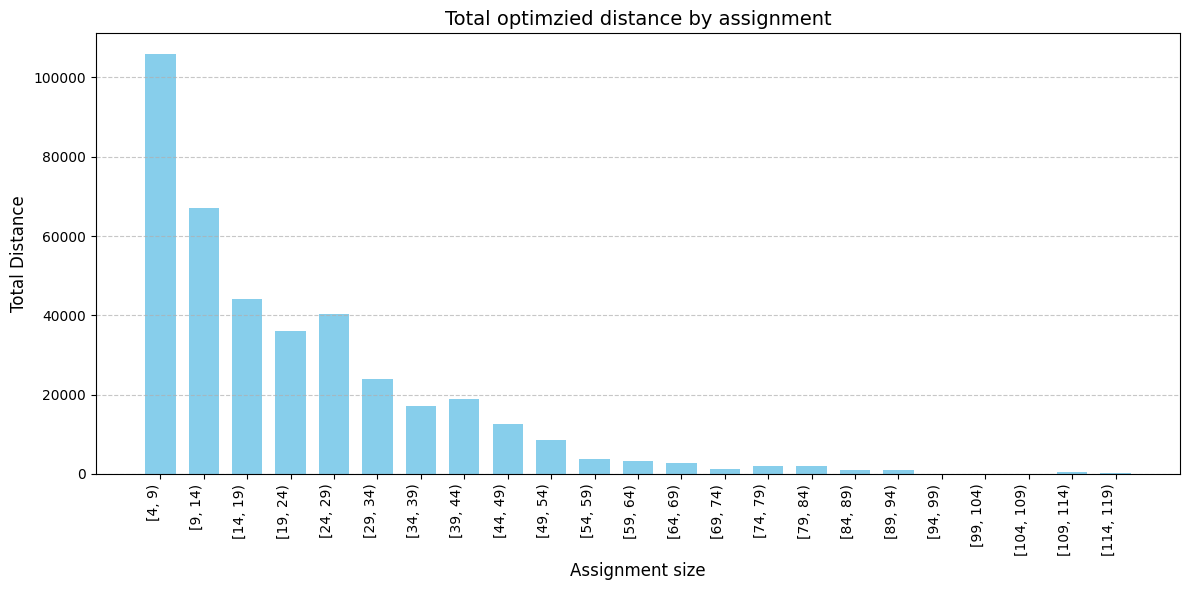

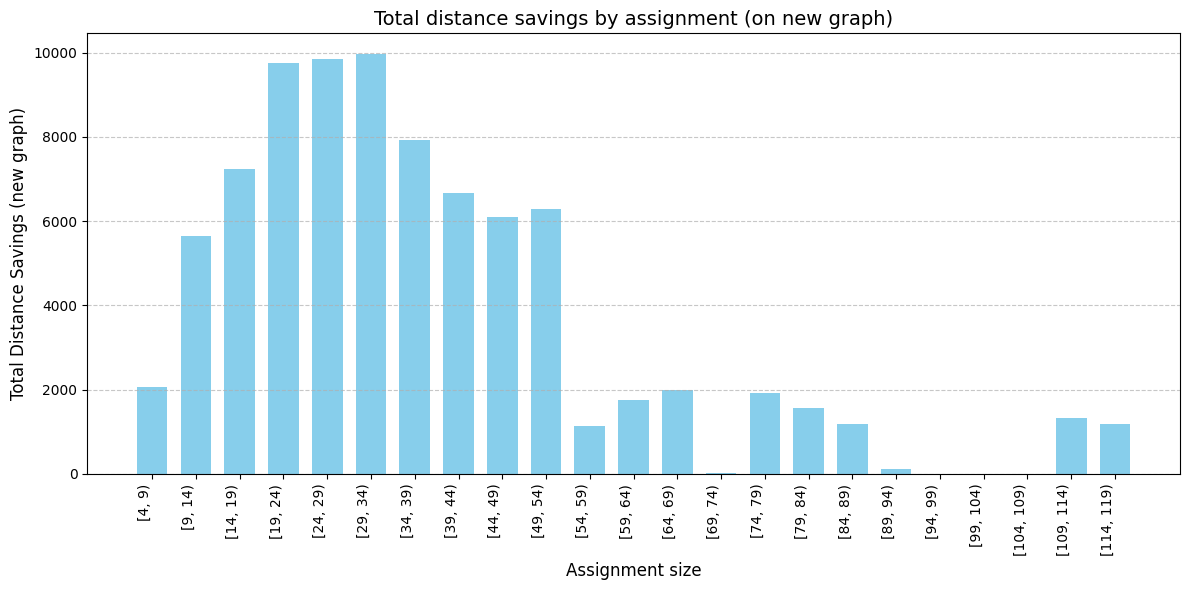

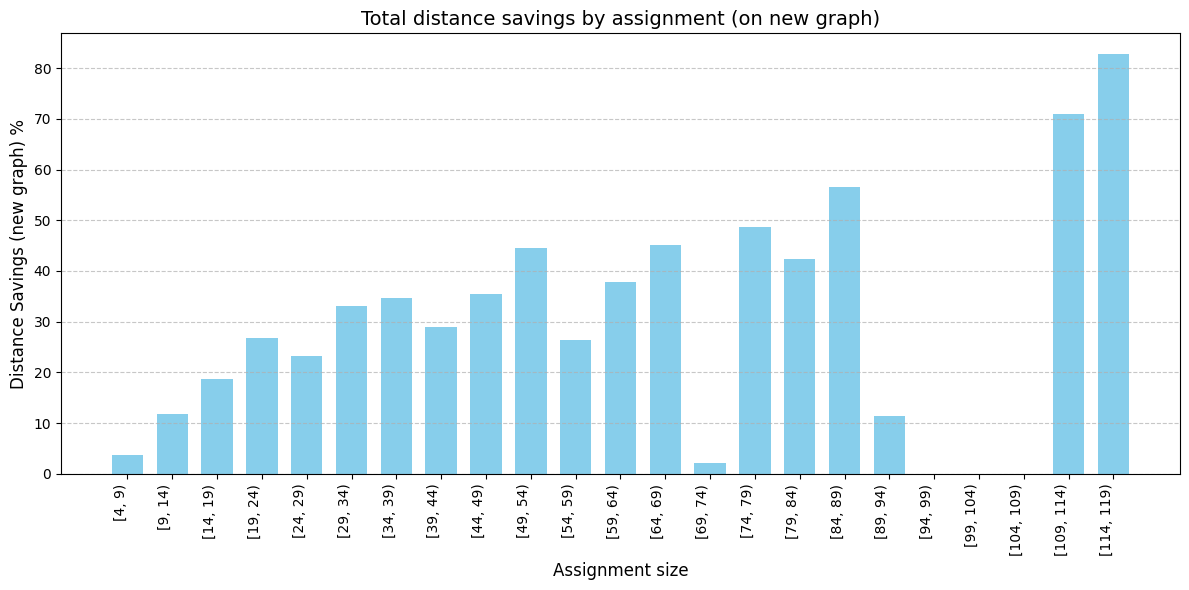

In [114]:
# saving for different buckets based on assignment size 
# bin_edges = range(3, 250, 2)  # Creates bins [0, 5), [5, 10), [10, 15), ..., [45, 50)

#bin_edges = [0, 3, 4]
#bin_edges.extend([i for i in range(5, 100, 5)])
bin_edges = range(4, 120, 5)
print(bin_edges)

bins = pd.cut(filter_historical_versus_optimzied_df['opt_assignment_length'], bins=bin_edges, right=False)

filter_historical_versus_optimzied_df['DistanceSavings (new graph)'] = filter_historical_versus_optimzied_df['unopt'] - filter_historical_versus_optimzied_df['opt']

result = filter_historical_versus_optimzied_df.groupby(bins).agg({'OptimizedDistance': ['sum', 'median', 'mean'], 
                                                                  'UnoptimizedDistance': ['sum', 'median', 'mean'], 
                                                                  'DistanceSavings': ['sum', 'median', 'mean'],
                                                                  'opt': ['sum', 'median', 'mean'], 
                                                                  'unopt': ['sum', 'median', 'mean'],
                                                                  'DistanceSavings (new graph)': ['sum', 'median', 'mean'],
                                                                  'worst': 'sum',
                                                                  'equal': 'sum', 
                                                                  'better': 'sum'
                                                                 }).reset_index()

result['% improvment'] = result['DistanceSavings']['sum']/result['UnoptimizedDistance']['sum']*100
result['% improvment (new graph)'] = result['DistanceSavings (new graph)']['sum']/result['unopt']['sum']*100

result['opt_assignment_length'] = result['opt_assignment_length'].astype('str')

# Plot the bar chart
plt.figure(figsize=(12, 6))
ax = result[['opt_assignment_length', 'worst', 'equal', 'better']].set_index('opt_assignment_length').plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Assignment size', fontsize=12)
plt.ylabel('total numbers', fontsize=12)
plt.title('Total counts of worst, better, and equal by assignment', fontsize=14)
plt.xticks(rotation=90, ha='right', fontsize=10)  
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout() 
plt.savefig('plots/worst_better_sa_hist.png')

plt.figure(figsize=(12, 6))
plt.bar(result['opt_assignment_length'], result['DistanceSavings']['sum'], color='skyblue', width=0.7, align='center')
plt.xlabel('Assignment size', fontsize=12)
plt.ylabel('Total Distance Savings', fontsize=12)
plt.title('Total distance savings by assignment', fontsize=14)
plt.xticks(rotation=90, ha='right', fontsize=10)  
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout() 
plt.savefig('plots/total_distance_Saving.png')

plt.figure(figsize=(12, 6))
plt.bar(result['opt_assignment_length'], result['% improvment'], color='skyblue', width=0.7, align='center')
plt.xlabel('Assignment size', fontsize=12)
plt.ylabel('Total Percentage Savings', fontsize=12)
plt.title('(Total DistanceSavings)/(Total Historical Distance)*100 by assignment', fontsize=14)
plt.xticks(rotation=90, ha='right', fontsize=10)  
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout() 
plt.savefig('plots/percentage improvment.png')

plt.figure(figsize=(12, 6))
plt.bar(result['opt_assignment_length'], result['UnoptimizedDistance']['sum'], color='skyblue', width=0.7, align='center')
plt.xlabel('Assignment size', fontsize=12)
plt.ylabel('Total Distance', fontsize=12)
plt.title('Total unoptimzied distance by assignment', fontsize=14)
plt.xticks(rotation=90, ha='right', fontsize=10)  
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout() 
plt.savefig('plots/total_unoptimized_distance.png')

plt.figure(figsize=(12, 6))
plt.bar(result['opt_assignment_length'], result['OptimizedDistance']['sum'], color='skyblue', width=0.7, align='center')
plt.xlabel('Assignment size', fontsize=12)
plt.ylabel('Total Distance', fontsize=12)
plt.title('Total optimzied distance by assignment', fontsize=14)
plt.xticks(rotation=90, ha='right', fontsize=10)  
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout() 
plt.savefig('plots/total_optimized_distance.png')

# this is based on new graph
plt.figure(figsize=(12, 6))
plt.bar(result['opt_assignment_length'], result['DistanceSavings (new graph)']['sum'], color='skyblue', width=0.7, align='center')
plt.xlabel('Assignment size', fontsize=12)
plt.ylabel('Total Distance Savings (new graph)', fontsize=12)
plt.title('Total distance savings by assignment (on new graph)', fontsize=14)
plt.xticks(rotation=90, ha='right', fontsize=10)  
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout() 
plt.savefig('plots/total_distance_saving_new_graph.png')

plt.figure(figsize=(12, 6))
plt.bar(result['opt_assignment_length'], result['% improvment (new graph)'], color='skyblue', width=0.7, align='center')
plt.xlabel('Assignment size', fontsize=12)
plt.ylabel('Distance Savings (new graph) %', fontsize=12)
plt.title('Total distance savings by assignment (on new graph)', fontsize=14)
plt.xticks(rotation=90, ha='right', fontsize=10)  
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout() 
plt.savefig('plots/total_percentage_saving_new_graph.png')

In [115]:
bin_edges = [4, 10, 50, 100, 150]
print(bin_edges)

filter_historical_versus_optimzied_df['num_tasks'] = filter_historical_versus_optimzied_df['opt_assignment_length']
bins = pd.cut(filter_historical_versus_optimzied_df['opt_assignment_length'], bins=bin_edges, right=False)

filter_historical_versus_optimzied_df['DistanceSavings (new graph)'] = filter_historical_versus_optimzied_df['unopt'] - filter_historical_versus_optimzied_df['opt']
filter_historical_versus_optimzied_df['DistanceSavings (old graph)'] = filter_historical_versus_optimzied_df['UnoptimizedDistance'] - filter_historical_versus_optimzied_df['OptimizedDistance']

result = filter_historical_versus_optimzied_df.groupby([bins, 'pick_type']).agg({'num_tasks': ['sum', 'mean'],
                                                                                 'OptimizedDistance': ['sum'], 
                                                                  'UnoptimizedDistance': ['sum'], 
                                                                  'DistanceSavings (old graph)': ['sum', 'median', 'mean', 'min', 'max'],
                                                                  'opt': ['sum'], 
                                                                  'unopt': ['sum'],
                                                                  'DistanceSavings (new graph)': ['sum', 'median', 'mean', 'min', 'max'],
                                                                  'worst': 'sum',
                                                                  'equal': 'sum', 
                                                                  'better': 'sum' 
                                                                 }).reset_index()

result['count'] = filter_historical_versus_optimzied_df.groupby([bins, 'pick_type']).size().reset_index(name='count')['count']
result['frequency'] = (result['count'] / result['count'].sum()) * 100

mean_distance_savings_new_graph = result['DistanceSavings (new graph)']['mean'].round(2)
result['total distance saved (new_graph)'] = result['frequency'] * mean_distance_savings_new_graph
mean_distance_savings_old_graph = result['DistanceSavings (old graph)']['mean'].round(2)
result['total distance saved (old_graph)'] = result['frequency'] * mean_distance_savings_old_graph
result = result[['opt_assignment_length', 
            'pick_type', 
            'count', 
            'num_tasks', 
            'frequency', 
            'UnoptimizedDistance', 
            'unopt',
            'DistanceSavings (old graph)', 
            'DistanceSavings (new graph)',
            'total distance saved (old_graph)', 
            'total distance saved (new_graph)']].dropna()

result = result.rename(columns={
    'opt_assignment_length': 'length', 
    'count': 'num assignments', 
    'num_tasks': 'num tasks', 
    'UnoptimizedDistance': 'hist distance (old graph)', 
    'unopt': 'hist distance (new graph)' })

result['Avg Distance Saved Per Task'] =  result['DistanceSavings (new graph)']['mean']/result['num tasks']['mean']
result['Avg Distance Saved Per Assignment'] =  result['DistanceSavings (new graph)']['sum']/result['num assignments']

result['Avg Dis Saved Per Task (old)'] =  result['DistanceSavings (old graph)']['mean']/result['num tasks']['mean']
result['Avg Dis Saved Per Assignment (old)'] =  result['DistanceSavings (old graph)']['sum']/result['num assignments']

result['% contribution (new_graph)'] =  result['DistanceSavings (new graph)']['sum']/sum(result['DistanceSavings (new graph)']['sum'])*100
result['% contribution (old_graph)'] =  result['DistanceSavings (old graph)']['sum']/sum(result['DistanceSavings (old graph)']['sum'])*100

result['% improvement (new graph)'] =  result['DistanceSavings (new graph)']['sum']/result['hist distance (new graph)']['sum']*100
result['% improvement (old graph)'] =  result['DistanceSavings (old graph)']['sum']/result['hist distance (old graph)']['sum']*100

df_old = result[['length', 
        'pick_type', 
        'num assignments', 
        'num tasks', 
        'frequency', 
        'hist distance (old graph)',
        'DistanceSavings (old graph)', 
        '% contribution (old_graph)', 
        '% improvement (old graph)',
        'Avg Distance Saved Per Task',
        'Avg Distance Saved Per Assignment']].round(2)


df_new = result[['length', 
        'pick_type', 
        'num assignments', 
        'num tasks', 
        'frequency', 
        'hist distance (new graph)',
        'DistanceSavings (new graph)', 
        '% contribution (new_graph)',
        '% improvement (new graph)',
        'Avg Distance Saved Per Task',
        'Avg Distance Saved Per Assignment']].round(2)

df_new['DistanceSavings (new graph)']['sum']/df_new['hist distance (new graph)']['sum']

df_new

[4, 10, 50, 100, 150]


C:\Users\Hasan\AppData\Local\Temp\ipykernel_22536\1212806768.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_historical_versus_optimzied_df['num_tasks'] = filter_historical_versus_optimzied_df['opt_assignment_length']
C:\Users\Hasan\AppData\Local\Temp\ipykernel_22536\1212806768.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_historical_versus_optimzied_df['DistanceSavings (new graph)'] = filter_historical_versus_optimzied_df['unopt'] - filter_historical_versus_optimzied_df['opt']
C:\Us

length         pick_type num assignments num tasks         frequency  \
                                                       sum    mean             
0      [4, 10)  Discrete Picking             793      4609    5.81     35.59   
1      [4, 10)       MIA Picking             115       709    6.17      5.16   
2      [4, 10)      Wave Picking              23       142    6.17      1.03   
3     [10, 50)  Discrete Picking             998     20737   20.78     44.79   
4     [10, 50)       MIA Picking             203      4847   23.88      9.11   
5     [10, 50)      Wave Picking              26       555   21.35      1.17   
6    [50, 100)  Discrete Picking              48      2924   60.92      2.15   
7    [50, 100)       MIA Picking              19      1256   66.11      0.85   
8    [50, 100)      Wave Picking               1        54   54.00      0.04   
10  [100, 150)       MIA Picking               2       227  113.50      0.09   

   hist distance (new graph) DistanceSavings (new graph)                    \
                         sum                         sum   median     mean   
0                   49662.14                     1209.25     0.00     1.52   
1                   10908.71                     1009.03     0.00     8.77   
2                    2883.92                      182.25     5.18     7.92   
3                  187353.93                    47445.60     3.40    47.54   
4                   57871.29                    16391.16    19.87    80.74   
5                    7822.74                      233.60    -0.24     8.98   
6                   26773.18                    10913.56    52.10   227.37   
7                    9885.51                     3817.44    -5.57   200.92   
8                       1.83                        0.00     0.00     0.00   
10                   3297.98                     2509.10  1254.55  1254.55   

                     % contribution (new_graph) % improvement (new graph)  \
        min      max                                                        
0    -63.74   113.33                       1.44                      2.43   
1    -56.97   150.86                       1.21                      9.25   
2    -32.16    54.51                       0.22                      6.32   
3    -77.91   873.04                      56.68                     25.32   
4   -175.91   737.68                      19.58                     28.32   
5    -55.91    92.83                       0.28                      2.99   
6    -92.01  1513.72                      13.04                     40.76   
7   -171.81  1219.64                       4.56                     38.62   
8      0.00     0.00                       0.00                      0.00   
10  1189.00  1320.10                       3.00                     76.08   

   Avg Distance Saved Per Task Avg Distance Saved Per Assignment  
                                                                  
0                         0.26                              1.52  
1                         1.42                              8.77  
2                         1.28                              7.92  
3                         2.29                             47.54  
4                         3.38                             80.74  
5                         0.42                              8.98  
6                         3.73                            227.37  
7                         3.04                            200.92  
8                         0.00                              0.00  
10                       11.05                           1254.55

range(4, 120, 5)


C:\Users\Hasan\AppData\Local\Temp\ipykernel_22536\3152871246.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_historical_versus_optimzied_df['DistanceSavings (new graph)'] = filter_historical_versus_optimzied_df['unopt'] - filter_historical_versus_optimzied_df['opt']
C:\Users\Hasan\AppData\Local\Temp\ipykernel_22536\3152871246.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 6))


<Figure size 1200x600 with 0 Axes>

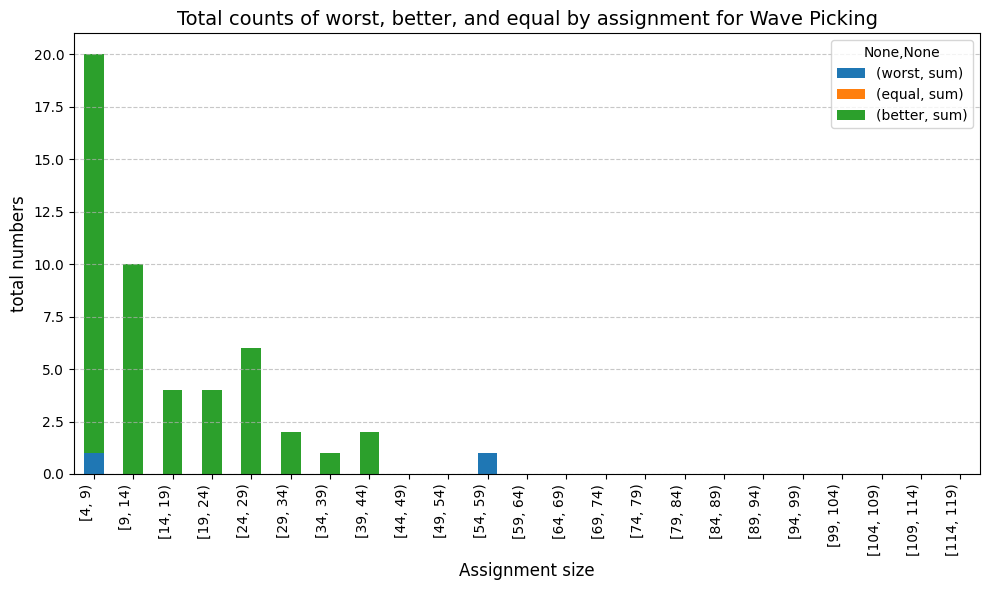

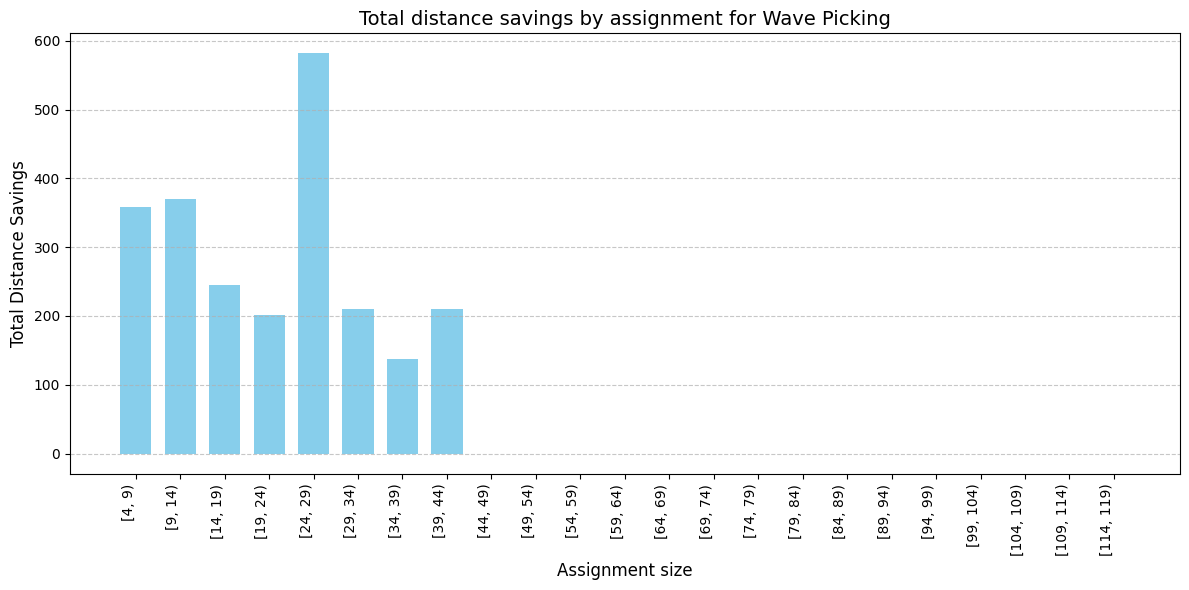

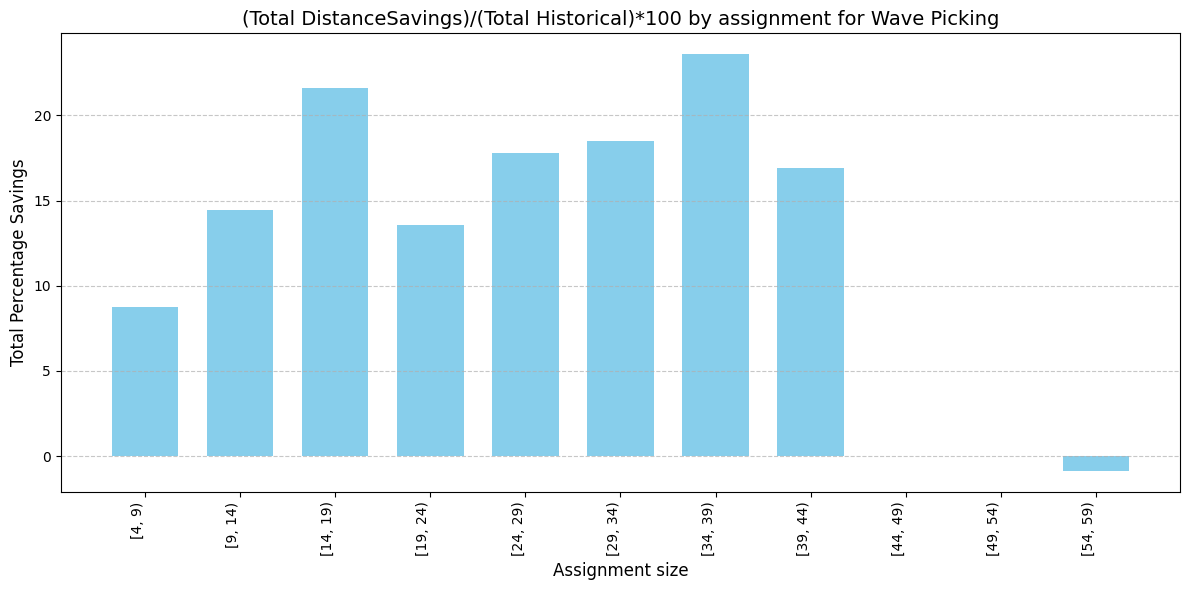

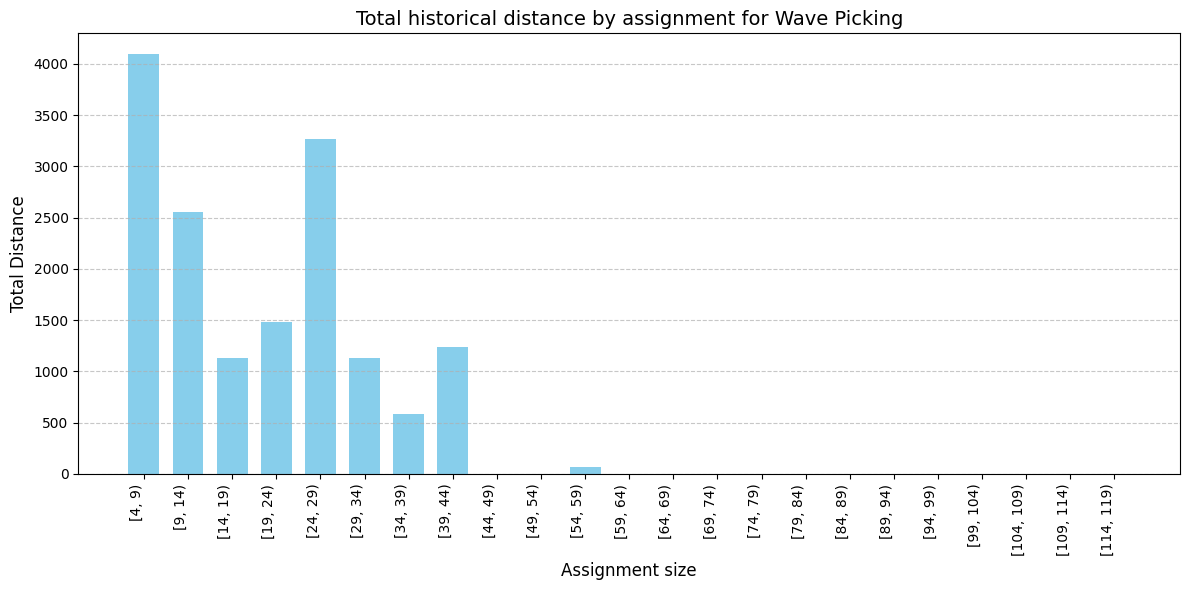

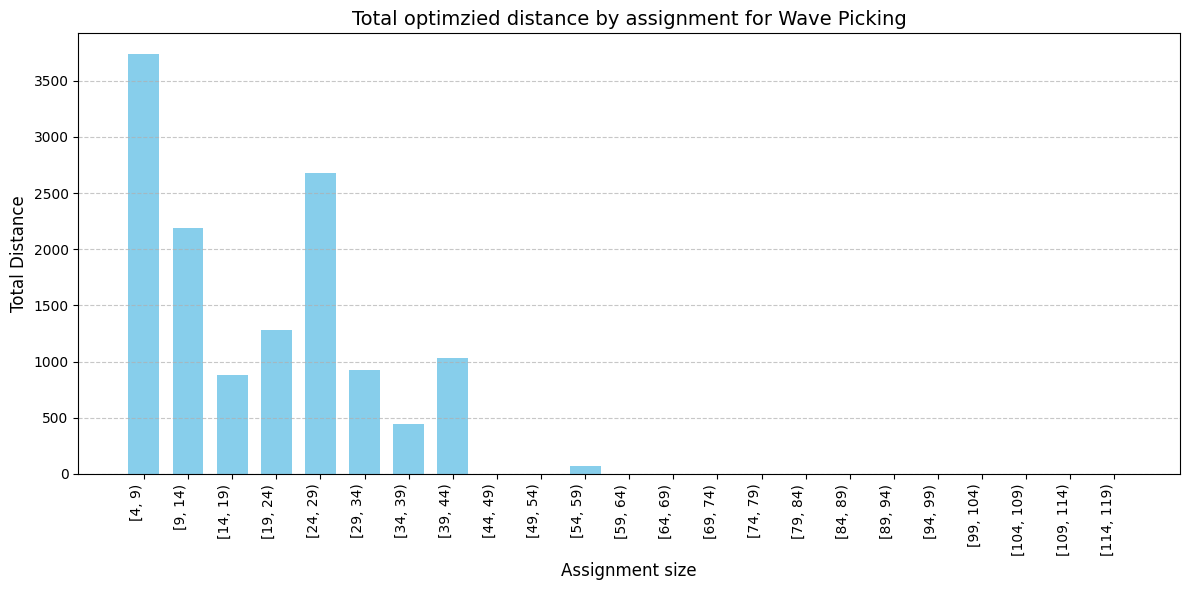

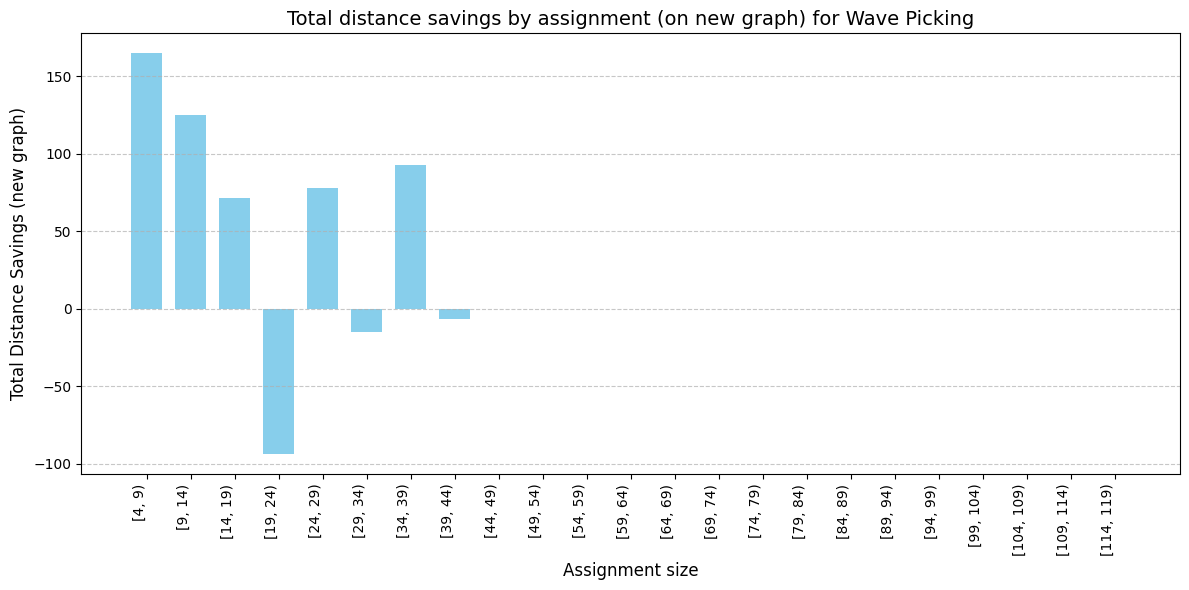

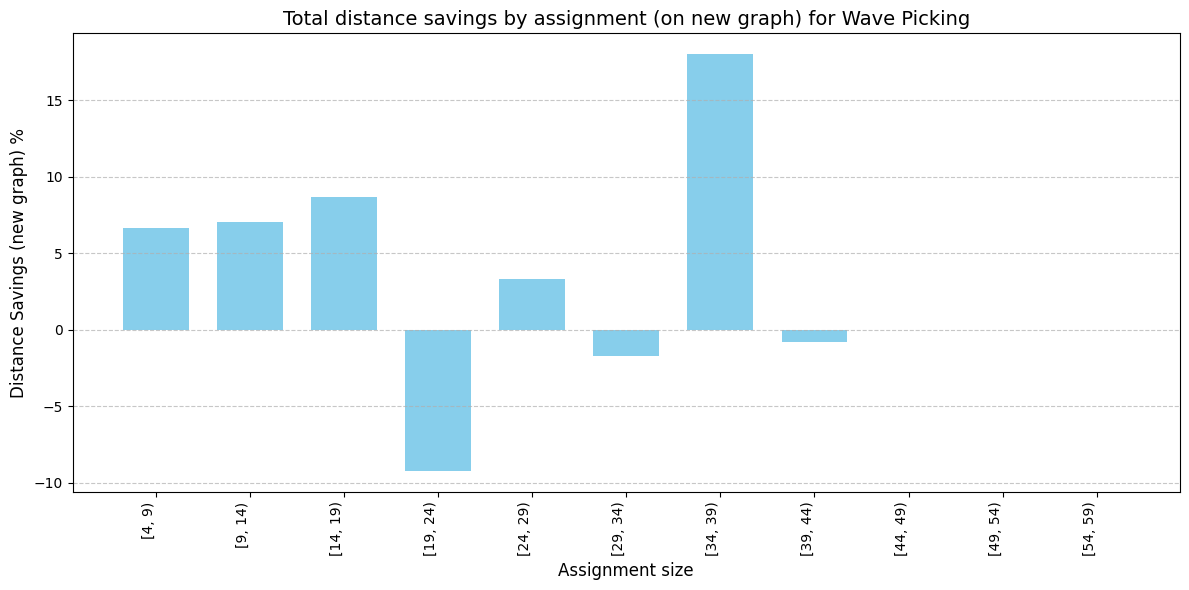

<Figure size 1200x600 with 0 Axes>

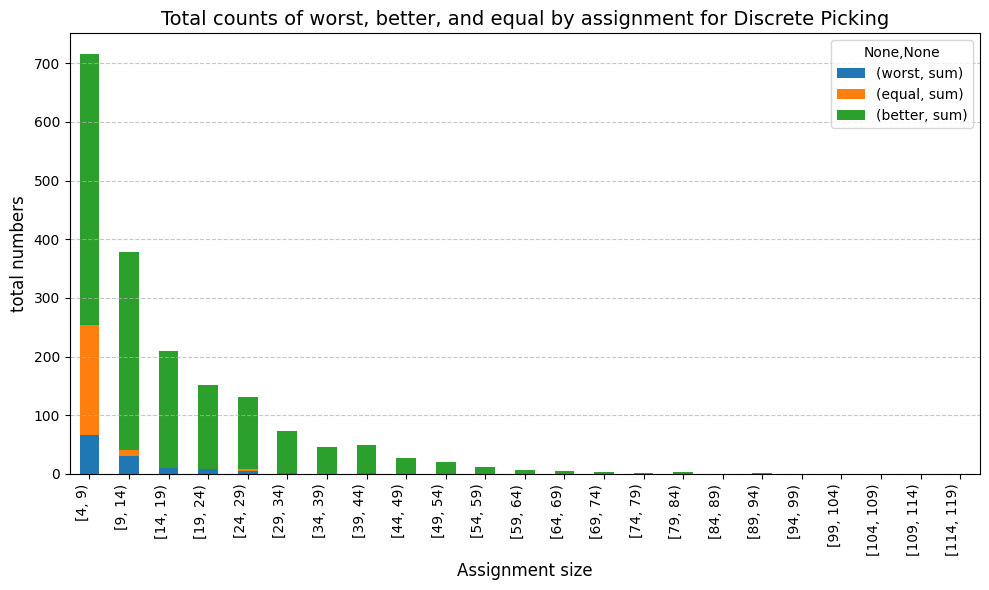

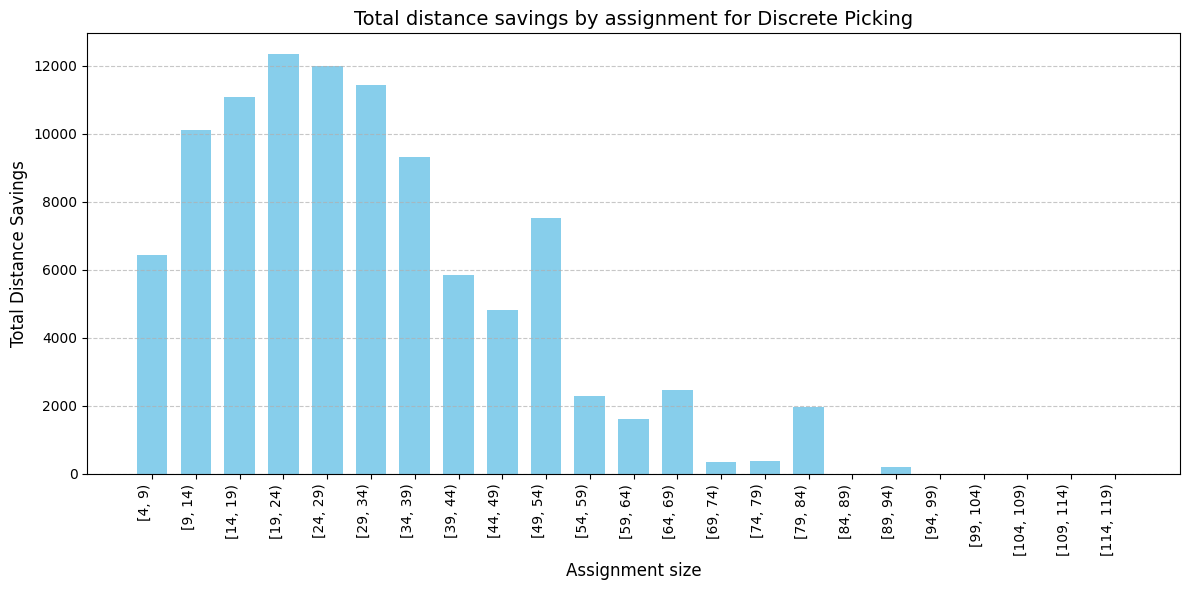

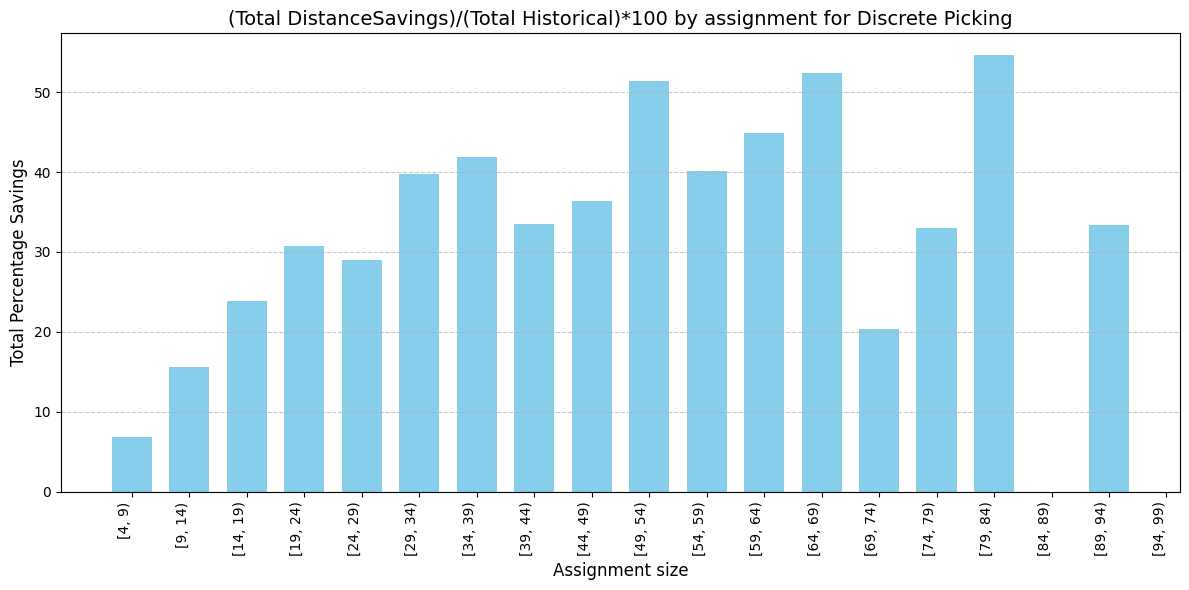

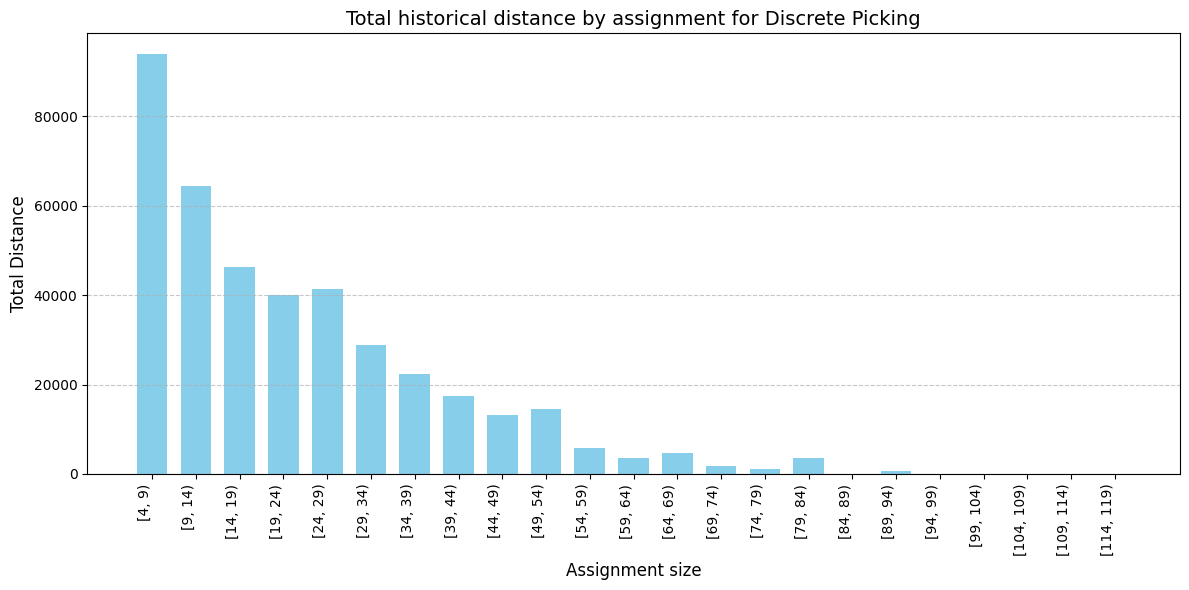

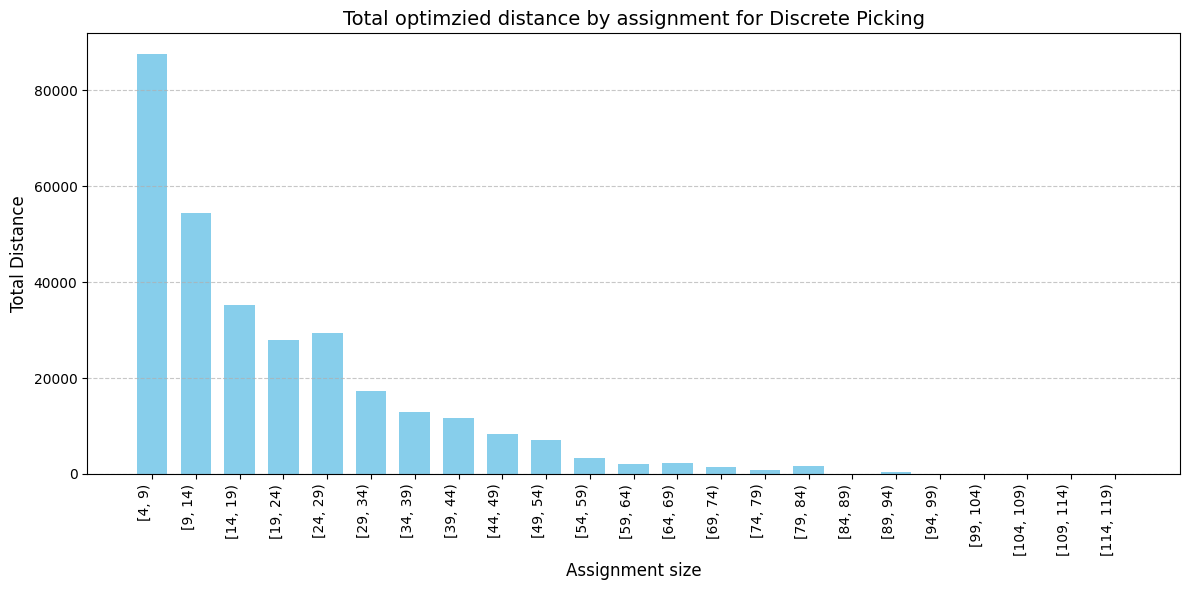

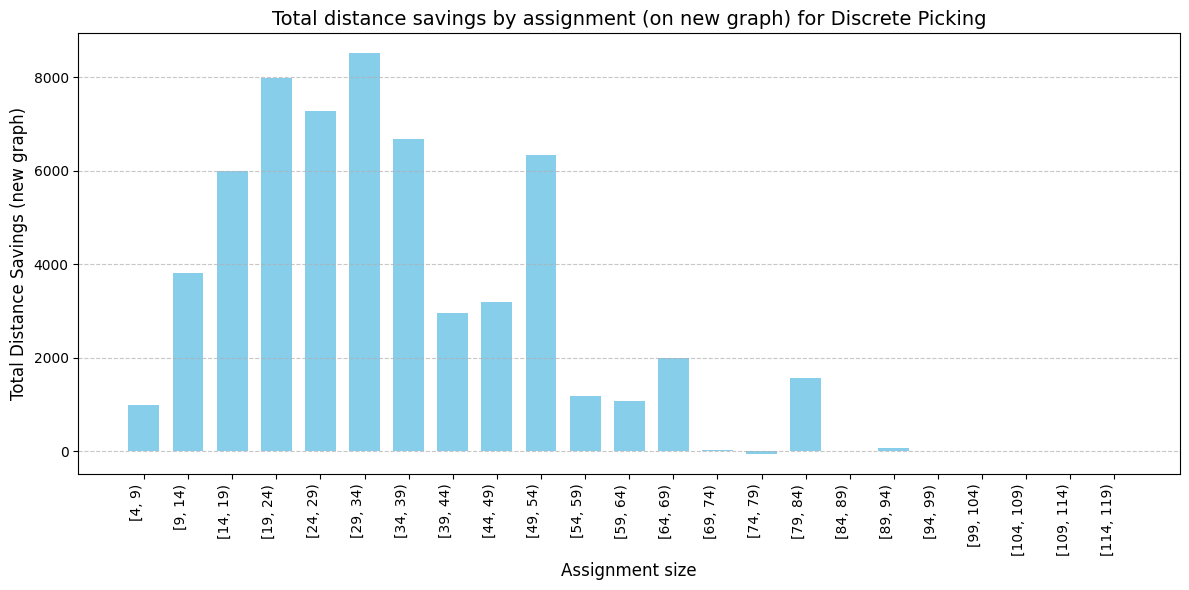

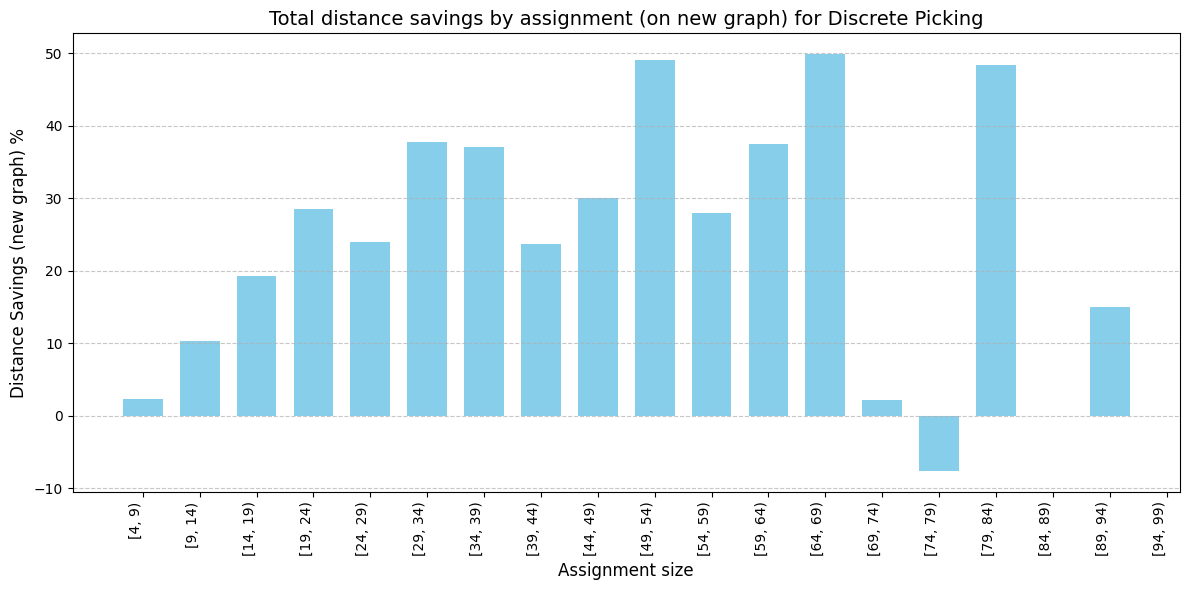

<Figure size 1200x600 with 0 Axes>

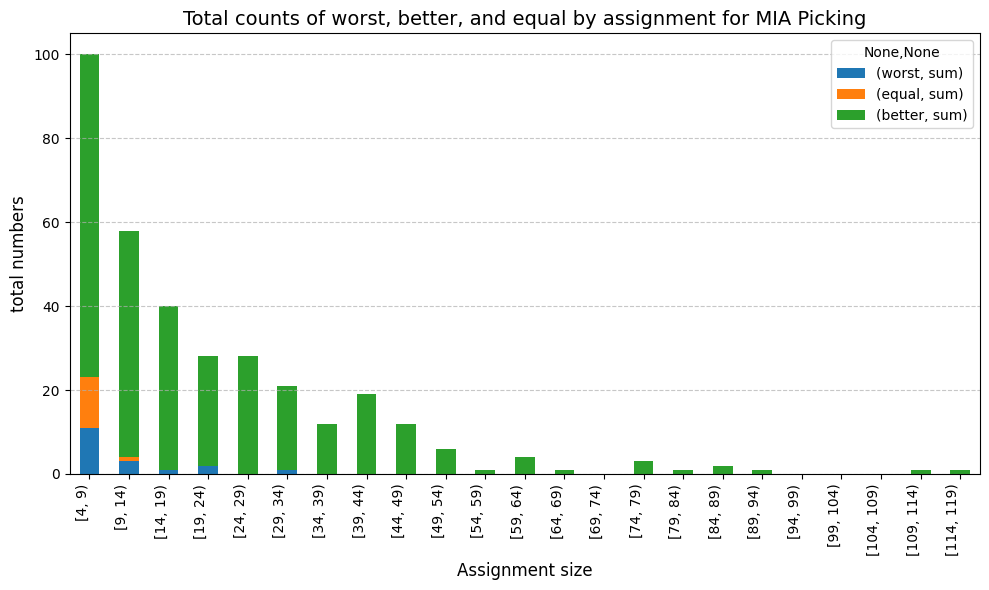

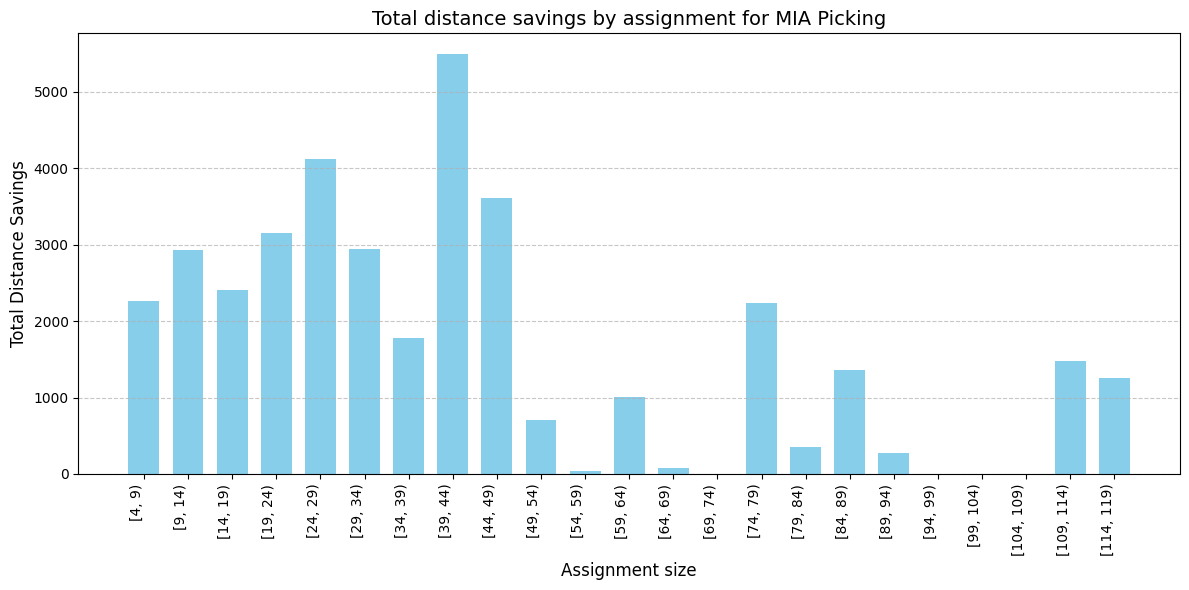

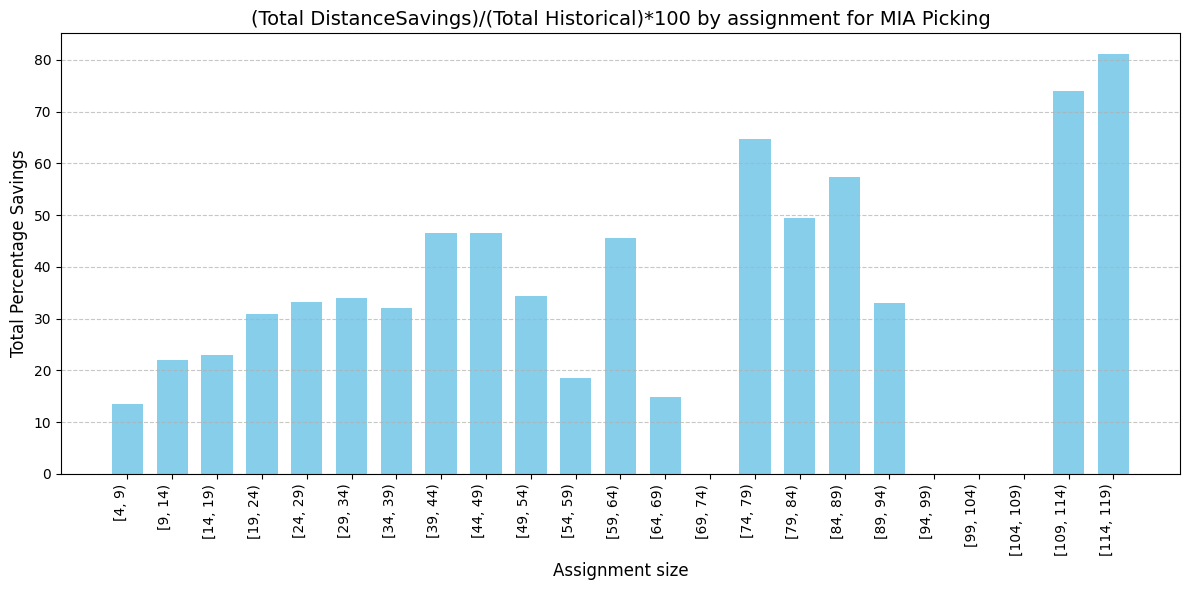

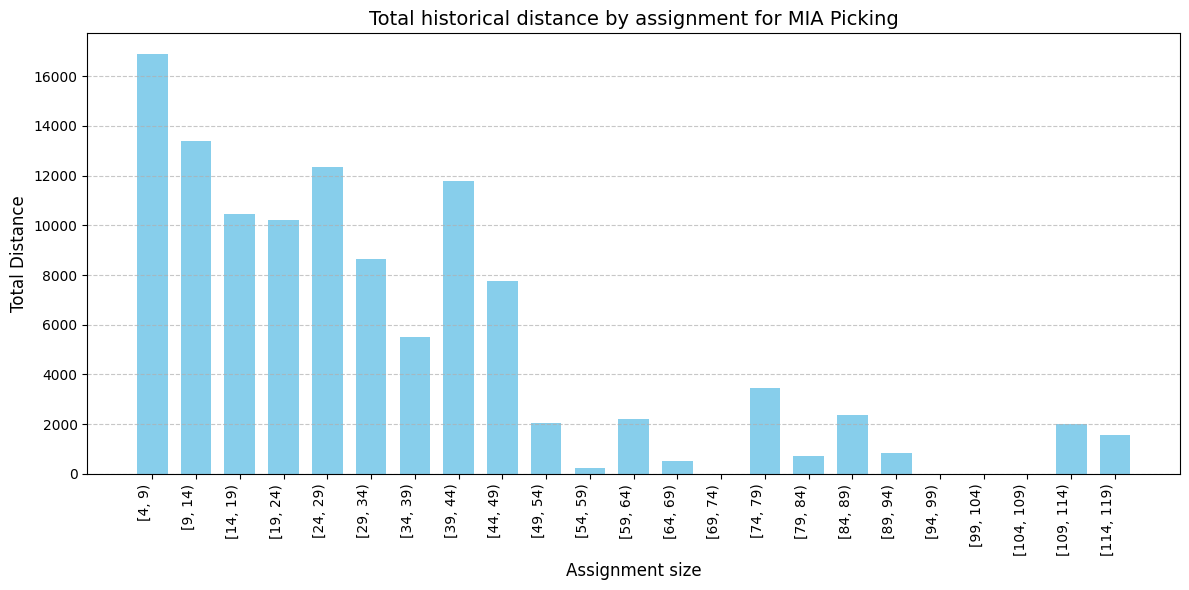

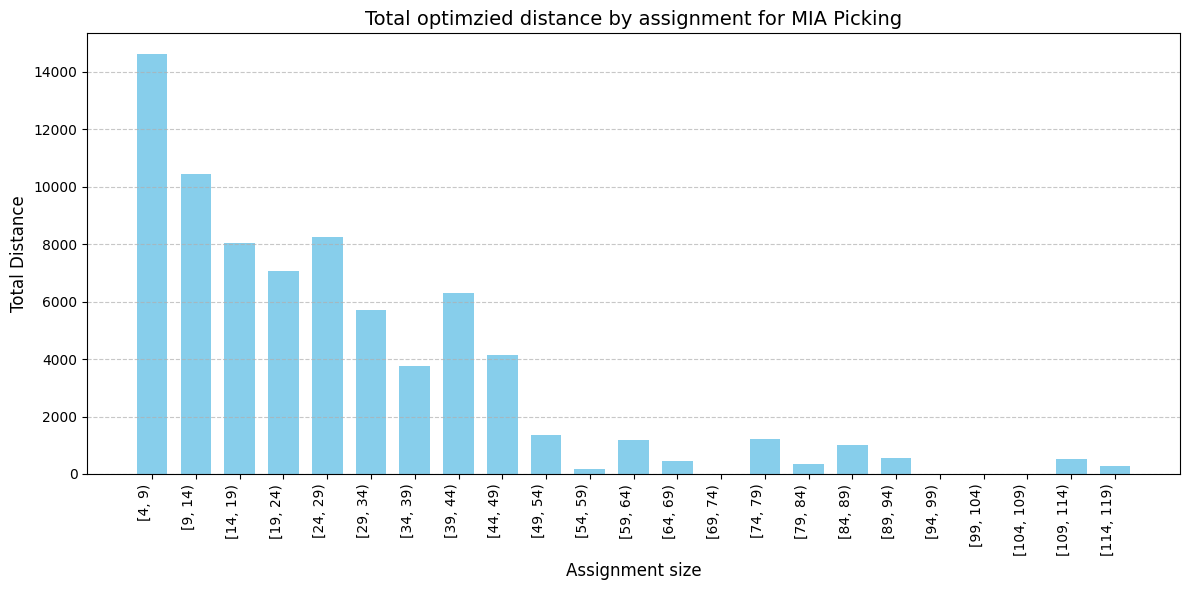

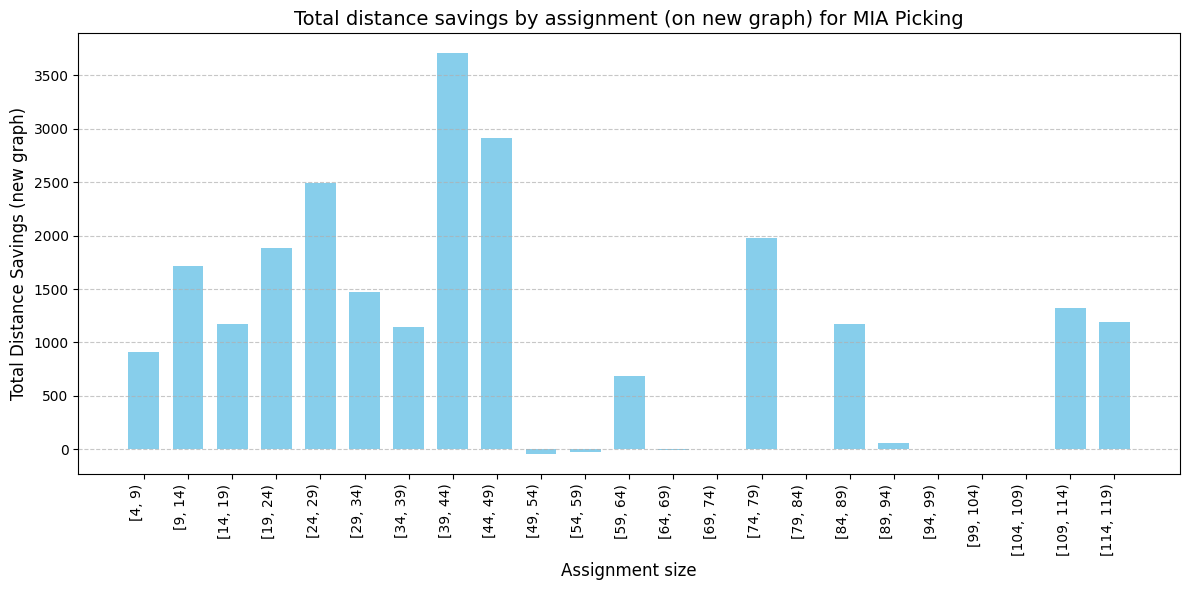

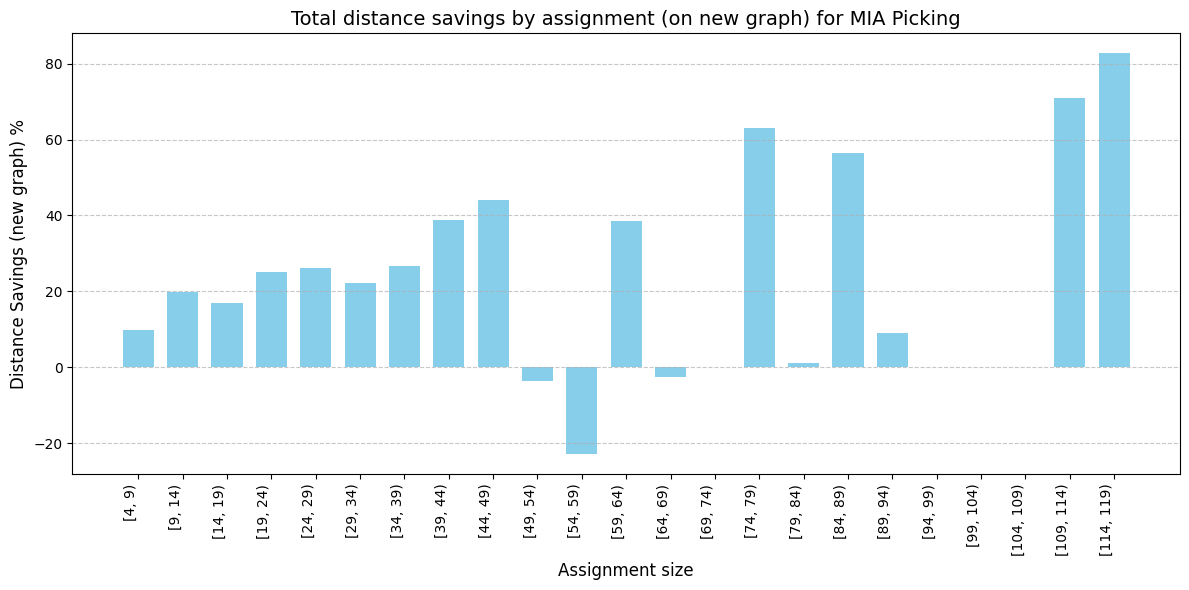

In [117]:
# for each pick type and assignment size 

bin_edges = [0, 3, 4]
bin_edges.extend([i for i in range(5, 250, 5)])
bin_edges = range(4, 120, 5)
print(bin_edges)

bins = pd.cut(filter_historical_versus_optimzied_df['opt_assignment_length'], bins=bin_edges, right=False)

filter_historical_versus_optimzied_df['DistanceSavings (new graph)'] = filter_historical_versus_optimzied_df['unopt'] - filter_historical_versus_optimzied_df['opt']


for pick_type in ['Wave Picking', 'Discrete Picking', 'MIA Picking']:
    df = filter_historical_versus_optimzied_df[filter_historical_versus_optimzied_df['pick_type']==pick_type]

    result = df.groupby(bins).agg({'OptimizedDistance': ['sum', 'median', 'mean'], 
                                                                      'UnoptimizedDistance': ['sum', 'median', 'mean'], 
                                                                      'DistanceSavings': ['sum', 'median', 'mean'],
                                                                      'opt': ['sum', 'median', 'mean'], 
                                                                      'unopt': ['sum', 'median', 'mean'],
                                                                      'DistanceSavings (new graph)': ['sum', 'median', 'mean'],
                                                                      'worst': 'sum',
                                                                      'equal': 'sum', 
                                                                      'better': 'sum'
                                                                     }).reset_index()
    
    result['% improvment'] = result['DistanceSavings']['sum']/result['UnoptimizedDistance']['sum']*100
    result['% improvment (new graph)'] = result['DistanceSavings (new graph)']['sum']/result['unopt']['sum']*100
    
    result['opt_assignment_length'] = result['opt_assignment_length'].astype('str')
    
    
    # Plot the bar chart
    plt.figure(figsize=(12, 6))
    ax = result[['opt_assignment_length', 'worst', 'equal', 'better']].set_index('opt_assignment_length').plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.xlabel('Assignment size', fontsize=12)
    plt.ylabel('total numbers', fontsize=12)
    plt.title(f'Total counts of worst, better, and equal by assignment for {pick_type}', fontsize=14)
    plt.xticks(rotation=90, ha='right', fontsize=10)  
    plt.grid(axis='y', linestyle='--', alpha=0.7) 
    plt.tight_layout() 
    plt.savefig(f'plots/worst_better_{pick_type}.png')
    
    plt.figure(figsize=(12, 6))
    plt.bar(result['opt_assignment_length'], result['DistanceSavings']['sum'], color='skyblue', width=0.7, align='center')
    plt.xlabel('Assignment size', fontsize=12)
    plt.ylabel('Total Distance Savings', fontsize=12)
    plt.title(f'Total distance savings by assignment for {pick_type}', fontsize=14)
    plt.xticks(rotation=90, ha='right', fontsize=10)  
    plt.grid(axis='y', linestyle='--', alpha=0.7) 
    plt.tight_layout() 
    plt.savefig(f'plots/total_distance_Saving_{pick_type}.png')
    
    plt.figure(figsize=(12, 6))
    plt.bar(result['opt_assignment_length'], result['% improvment'], color='skyblue', width=0.7, align='center')
    plt.xlabel('Assignment size', fontsize=12)
    plt.ylabel('Total Percentage Savings', fontsize=12)
    plt.title(f'(Total DistanceSavings)/(Total Historical)*100 by assignment for {pick_type}', fontsize=14)
    plt.xticks(rotation=90, ha='right', fontsize=10)  
    plt.grid(axis='y', linestyle='--', alpha=0.7) 
    plt.tight_layout() 
    plt.savefig(f'plots/percentage improvment_{pick_type}.png')
    
    plt.figure(figsize=(12, 6))
    plt.bar(result['opt_assignment_length'], result['UnoptimizedDistance']['sum'], color='skyblue', width=0.7, align='center')
    plt.xlabel('Assignment size', fontsize=12)
    plt.ylabel('Total Distance', fontsize=12)
    plt.title(f'Total historical distance by assignment for {pick_type}', fontsize=14)
    plt.xticks(rotation=90, ha='right', fontsize=10)  
    plt.grid(axis='y', linestyle='--', alpha=0.7) 
    plt.tight_layout() 
    plt.savefig(f'plots/total_unoptimized_distance_{pick_type}.png')
    
    plt.figure(figsize=(12, 6))
    plt.bar(result['opt_assignment_length'], result['OptimizedDistance']['sum'], color='skyblue', width=0.7, align='center')
    plt.xlabel('Assignment size', fontsize=12)
    plt.ylabel('Total Distance', fontsize=12)
    plt.title(f'Total optimzied distance by assignment for {pick_type}', fontsize=14)
    plt.xticks(rotation=90, ha='right', fontsize=10)  
    plt.grid(axis='y', linestyle='--', alpha=0.7) 
    plt.tight_layout() 
    plt.savefig(f'plots/total_optimized_distance_{pick_type}.png')

    # this is based on new graph
    plt.figure(figsize=(12, 6))
    plt.bar(result['opt_assignment_length'], result['DistanceSavings (new graph)']['sum'], color='skyblue', width=0.7, align='center')
    plt.xlabel('Assignment size', fontsize=12)
    plt.ylabel('Total Distance Savings (new graph)', fontsize=12)
    plt.title(f'Total distance savings by assignment (on new graph) for {pick_type}', fontsize=14)
    plt.xticks(rotation=90, ha='right', fontsize=10)  
    plt.grid(axis='y', linestyle='--', alpha=0.7) 
    plt.tight_layout() 
    plt.savefig(f'plots/total_distance_Saving_new_graph_{pick_type}.png')

    plt.figure(figsize=(12, 6))
    plt.bar(result['opt_assignment_length'], result['% improvment (new graph)'], color='skyblue', width=0.7, align='center')
    plt.xlabel('Assignment size', fontsize=12)
    plt.ylabel('Distance Savings (new graph) %', fontsize=12)
    plt.title(f'Total distance savings by assignment (on new graph) for {pick_type}', fontsize=14)
    plt.xticks(rotation=90, ha='right', fontsize=10)  
    plt.grid(axis='y', linestyle='--', alpha=0.7) 
    plt.tight_layout() 
    plt.savefig(f'plots/total_percentage_saving_new_graph_{pick_type}.png')

In [ ]:
# hist freq 
historical_length_freq = historical_assginment['hist_assignment_length'][historical_assginment['hist_assignment_length']>2].value_counts().reset_index()
historical_length_freq.columns = ['hist_assignment_length','hist_count']
total_count = historical_length_freq['hist_count'].sum()
historical_length_freq['hist_freq'] = (historical_length_freq['hist_count'] / total_count) * 100

# opt freq 
opt_length_freq = filter_historical_versus_optimzied_df['opt_assignment_length'].value_counts().reset_index()
opt_length_freq.columns = ['opt_assignment_length', 'opt_count']
total_count = opt_length_freq['opt_count'].sum()
opt_length_freq['opt_freq'] = (opt_length_freq['opt_count'] / total_count) * 100

# create a freq_table 
freq_table = pd.merge(historical_length_freq, 
                      opt_length_freq, 
                      left_on='hist_assignment_length', 
                      right_on='opt_assignment_length', 
                      how='right')
freq_table.head()

# Estimate computational time

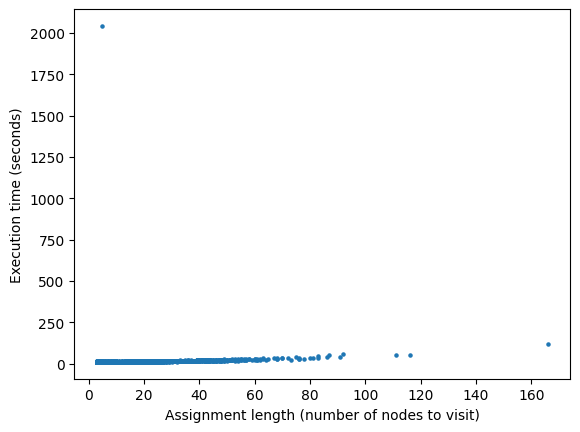

In [118]:
historical_versus_optimzied_df["ExecutionTime"].mean()
historical_versus_optimzied_df["ExecutionTime"].max()
historical_versus_optimzied_df["ExecutionTime"].std()
df=historical_versus_optimzied_df
plt.scatter(df["opt_assignment_length"], df["ExecutionTime"], s=5)
plt.xlabel("Assignment length (number of nodes to visit)")
plt.ylabel("Execution time (seconds)")
plt.savefig('plots/computational time.png')

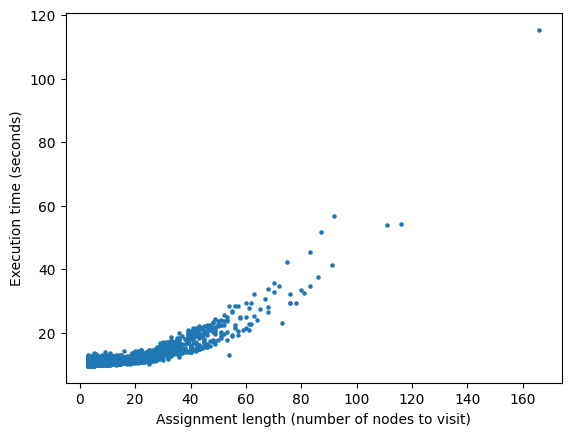

In [119]:
df = historical_versus_optimzied_df[(historical_versus_optimzied_df["ExecutionTime"] < 200) 
& ((historical_versus_optimzied_df["opt_assignment_length"] > 3) 
   | (historical_versus_optimzied_df["opt_assignment_length"] < 100))]
plt.scatter(df["opt_assignment_length"], df["ExecutionTime"], s=5)
plt.xlabel("Assignment length (number of nodes to visit)")
plt.ylabel("Execution time (seconds)")
plt.savefig('plots/computational time.png')